In [1]:
import pandas as pd
import numpy as np
import pyodbc as pyo
import csv
import os
import geopandas as gpd
import shapely
import fiona
from pivottablejs import pivot_ui
from IPython.display import display
import openpyxl
import matplotlib.pyplot as plt
from utils.db_conn import dbConnect
from utils.clean_data import persiIDAdj, CleanHousehold, CleanPerson
from utils.person_calculation import cal_cc_kid, cal_prim, cal_study_tag, cal_work_tag, cal_ageCat, cal_worker
from utils.purpose_define import cat_duration


# import plotly.express as px
from shapely.geometry import Point, LineString, Polygon
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
%%time
db_name = '2017-20 pooled SEQ QTS.accdb'
cnxn, cursor = dbConnect(db_name)

Wall time: 2.7 s


In [3]:
%%time
"""Import HTS Data."""

HOUSEHOLDS = pd.read_sql('SELECT * from {}'.format('1_QTS_HOUSEHOLDS'), con = cnxn).fillna(0)
PERSONS = pd.read_sql('SELECT * from {}'.format('2_QTS_PERSONS'), con = cnxn).fillna(0)
STOPS = pd.read_sql('SELECT * from {}'.format('4_QTS_STOPS'), con = cnxn).fillna(0)
TRIPS = pd.read_sql('SELECT * from {}'.format('5_QTS_TRIPS'), con = cnxn).fillna(0)
ANZSCO = pd.read_sql('SELECT * from {}'.format('R_ANZSCO'), con = cnxn).fillna(0)
ASGS = pd.read_sql('SELECT * from {}'.format('R_ASGS_2016'), con = cnxn).fillna(0)
# TIME = pd.read_sql('SELECT * from {}'.format('REFER_TIME'), con = cnxn).fillna(0)
TIME = pd.read_excel('..\Data\inputs\R_TIME.xlsx', engine = 'openpyxl').fillna(0)

Wall time: 28.4 s


In [4]:
"""Adjust PERSID."""
PERSONS = persiIDAdj(PERSONS)
TRIPS = persiIDAdj(TRIPS)
STOPS = persiIDAdj(STOPS)

In [5]:
PERSONS.drop(columns = ['STARTPLACE', 'ANYSTOPS', 'REASON', 'LASTLEFT','RELATIONSHIP', 'CARLICENCE', 'CARLICTYPE',
                        'MCLICENCE', 'MCLICTYPE', 'OTHERLICENCE','YEAROFBIRTH','ASSISTAGE', 'ASSISTLTHC', 'ASSISTSTHC',
                        'ASSISTDISABILITY','ASSISTENGLISH', 'ASSISTOTHER', 'ASSISTANY','RIDESHARETRIPS', 'RIDESHAREENT', 
                        'RIDESHAREHC', 'RIDESHAREED', 'RIDESHARESHOP', 'RIDESHAREWORK', 'RIDESHAREOTHER', 'TAXITRIPSS',
                        'TAXIENT', 'TAXIHC', 'TAXIED', 'TAXISHOP', 'TAXIWORK', 'TAXIOTHER'], 
             inplace = True)

HOUSEHOLDS.drop(columns= ['BIKES', 'HHVEH', 'DWELLTYPE', 'SURVEYWEEK',
       'STRATA_LGA', 'TRAVDATE', 'TRAVMONTH', 'TRAVYEAR', 'TRAVDOW'], inplace = True)

In [6]:
"""Load New Weightings"""
HH = pd.read_excel('../Data/inputs/Reweight.xlsx', engine='openpyxl', sheet_name='HH_export')
Pers = pd.read_excel('../Data/inputs/Reweight.xlsx', engine='openpyxl', sheet_name='Pers_export')
wgt_sect = pd.read_excel('../Data/inputs/Reweight.xlsx', engine='openpyxl', sheet_name='WGT_Sect')

In [7]:
"""Load Spatial Cordons"""
# zones = gpd.read_file(r'..\Data\inputs\spatial\SEQSTM_Zones_wExt_LvL4_vF2_withIslands.TAB')
# zones = zones.to_crs(epsg=4283)
# zones = zones.astype({'LvL4_ID':int, 'LvL3_ID':int, 'LvL2_ID':int, 'LvL1_ID': int, 'Dist_ID':int})
# zones = zones.fillna('N')
# zones = zones[['geometry','LvL4_ID', 'LvL3_ID', 'LvL2_ID', 'LvL1_ID', 'Dist_ID','SA2_NAME']]

# zones = pd.merge(zones, wgt_sect[['Dist_ID','WeightingSector']], on='Dist_ID')

district_path = r'Spatial Files\SEQSTM_Districts_vF.TAB' 
district = gpd.read_file(district_path, crs='EPSG:4283')
district = district.to_crs(epsg=4283)
district = district.astype({"Dist_ID": int})
district['SEQSTM'] = 'Y'

BSTM_path = r"Spatial Files\BSTM_Districts.TAB"
BSTM_district = gpd.read_file(BSTM_path, crs='EPSG:4283')
BSTM_district = BSTM_district.to_crs(epsg=4283)
BSTM_district = BSTM_district.astype({"Dist_ID": int})
BSTM_district['BSTM'] = 'Y'

zones = gpd.read_file(r'Spatial Files\SEQSTM_Zones_wExt_LvL4_vF2_withIslands.TAB')
zones = zones.to_crs(epsg=4283)
zones = zones.astype({'LvL4_ID':int, 'LvL3_ID':int, 'LvL2_ID':int, 'LvL1_ID': int, 'Dist_ID':int})
zones['SEQSTM'] = 'Y'
zones = pd.merge(zones,BSTM_district[['Dist_ID', 'BSTM']], how = 'left', on='Dist_ID').fillna('N')
zones = zones[['geometry','LvL4_ID', 'LvL3_ID', 'LvL2_ID', 'LvL1_ID', 'Dist_ID','SA2_NAME','SEQSTM','BSTM']]
zones = pd.merge(zones, wgt_sect[['Dist_ID','WeightingSector']], on='Dist_ID')
del BSTM_district, district

# Data Table Cleaning

## Households 

In [8]:
Household = CleanHousehold(HOUSEHOLDS, ASGS, zones, HH)

C:\Users\Karimi\Anaconda3\envs\imgenv\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(EPSG:4283 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


Number of Household Records in Original: 14715
Number of Household Records: 14715
LGA Weighting Population: 1167298.0
Sector Weighting Population: 1166010.0


## Person Table

In [9]:
""" Blue/White Collar Adjustment."""
adjustpath = os.getcwd()
try:
    ANZSCO_filter = pd.read_csv(os.path.join(adjustpath, '../Data/inputs/ANZSCO_adjustment.csv'))
    print('Using existing Blue/White Collar split table')
    #os.startfile(os.path.join(adjustpath, 'ANZSCO_adjustment.csv'))
except IOError:
    print('Rerun after completing Blue/White Collar split table')
    ANZSCO.reindex(ANZSCO.columns.tolist() + ['Collar', 'Collar2'], axis=1).drop(columns=['ANZSCO_2','Description_2',
    'ANZSCO_4','Description_4','ANZSCO_6', 'Description_6']).drop_duplicates().to_csv(os.path.join(adjustpath,'../Data/inputs/ANZSCO_adjustment.csv'), index= False)
    os.startfile(os.path.join(adjustpath, '../Data/inputs/ANZSCO_adjustment.csv'))


Using existing Blue/White Collar split table


In [10]:
print(os.path.join(adjustpath, '../Data/inputs/ANZSCO_adjustment.csv'))

H:\Transportation Project\Household_travel_survey\notebook_for_documentation (1)\../Data/inputs/ANZSCO_adjustment.csv


In [11]:
ANZSCO_filter.loc[~pd.isna(ANZSCO_filter.Collar)]

,ANZSCO_1,Description_1,ANZSCO_3,Description_3,Collar,Collar2
0,1,MANAGERS,100,Managers nfd,White,Professional
1,1,MANAGERS,141,Accommodation and Hospitality Managers,White,White
2,1,MANAGERS,149,"Miscellaneous Hospitality, Retail and Service ...",White,White
3,1,MANAGERS,132,Business Administration Managers,White,Professional
4,1,MANAGERS,131,"Advertising, Public Relations and Sales Managers",White,Professional
...,...,...,...,...,...,...
134,8,LABOURERS,891,Freight Handlers and Shelf Fillers,Blue,Blue
135,8,LABOURERS,890,Other Labourers nfd,Blue,Blue
136,9,MISCELLANEOUS,999,Response Unidentifiable,White,White
137,9,MISCELLANEOUS,997,Response Unidentifiable,White,White


In [12]:
Person = CleanPerson(PERSONS, Household, ANZSCO_filter, Pers)

Number of Person Records in Original: 36264
Number of Person Records: 36264


### Person Variables

**CC_kids Student Flowchart**
<img src="../Media/st_cc.jpg">

**Primary Student Flowchart**
<img src="../Media/st_prim.jpg">

**Secondary Student Flowchart**
<img src="../Media/st_sec.jpg">

**Tertiary Student Flowchart**
<img src="../Media/st_tert.jpg">

**Worker Flowchart**
<img src="../Media/worker.jpg">

**White Worker Flowchart**
<img src="../Media/w_worker.jpg">

**Blue Worker Flowchart**
<img src="../Media/b_worker.jpg">

In [13]:
"""Calculate Kindergarten/Childcare kids."""
Person = cal_cc_kid(TRIPS, Person)

Number of Added Kindy Kids:368


In [14]:
test = Person.loc[Person.Student_CC==1]
test.HH_SA4.value_counts()

Gold Coast             64
Sunshine Coast         54
Ipswich                47
Logan - Beaudesert     44
Brisbane - East        33
Brisbane - West        26
Brisbane - South       25
Brisbane Inner City    23
Moreton Bay - South    22
Brisbane - North       17
Moreton Bay - North    13
Name: HH_SA4, dtype: int64

In [15]:
"""Calculate Primary kids."""
Person = cal_prim(TRIPS, Person)

Number of Added Kindy Kids:52
Number of Added Primary Kids:24


In [16]:
Person = cal_study_tag(Person)
Person = cal_work_tag(Person)
Person = cal_ageCat(Person)

ERRORS PRESENT:0 Person Records without Variable attached
REVIEW PERSID:[] 


In [17]:
"""Calculate Workers."""
Person = cal_worker(TRIPS, Person)

Number of Added Workers:291
Number of Added Workers - White:6
Number of Added Workers - Blue:1
Number of Added Workers - None:284


In [18]:
grouped_person = Person[['PERSID','0-14', '15-29', '30-49','50-74', '75+','Age_cat', 'Dependent', 'Worker', 'Student','Worker_Blue', 'Worker_White', 'STUDYING' ,'Student_Prim', 'Student_Sec','Student_Tert','Student_CC', 'AGE','HHID']].groupby('HHID').agg({'PERSID': 'count','0-14': 'sum', '15-29': 'sum', '30-49': 'sum','50-74': 'sum', '75+': 'sum', 'Worker_Blue':'sum', 'Worker_White': 'sum','Worker': 'sum', 'Student_Prim': 'sum', 'Student_Sec': 'sum','Student_Tert': 'sum','Student_CC': 'sum','Student': 'sum', 'AGE': 'mean'}).rename(columns={'PERSID':'Residents'})
Household = pd.merge(Household, grouped_person, left_on = 'HHID', right_index = True)
del grouped_person


In [19]:
trip = TRIPS.copy()
trip = trip.astype({'TRIPID': 'int64', 'HHID':'int64', "PERSID": 'int64'})
trip['trip_stops'] = trip['ENDSTOP'] - trip['STARTSTOP']
#trip = pd.merge(trip, Person[['PERSID','Collar', 'AGE','HHID']], left_on = 'PERSID', right_on = 'PERSID',how='left').drop(columns='HHID_y').rename(columns={'HHID_x': 'HHID'})

# Atousa Modification:
trip = pd.merge(trip, Person[['PERSID','Collar','Collar2','WORKSTATUS', 'STUDYING','0-14', '15-29', '30-49','50-74', '75+','Age_cat', 'Dependent', 'Worker', 'Student','Worker_Blue', 'Worker_White', 'Student_Prim', 'Student_Sec','Student_Tert', 'Student_CC','AGE','HHID', 'HH_SA2', 'HH_SA3', 'HH_SA4', 'HH_LGA','Home_LvL4', 'Home_LvL3', 'Home_LvL2', 'Home_LvL1', 'Home_Dist', 'BSTM']], left_on = 'PERSID', right_on = 'PERSID', how='left').drop(columns='HHID_y').rename(columns={'HHID_x': 'HHID','SA2_NAME_2016': "HH_SA2", 'SA3_NAME_2016': "HH_SA3", 'SA4_NAME_2016': "HH_SA4", 'LGA_NAME_2016': "HH_LGA", 'BSTM': 'HH_BSTM'})
# trip = pd.merge(trip, Person[['PERSID','Collar','Collar2','WORKSTATUS', 'STUDYING','0-14', '15-29', '30-49','50-74', '75+','Age_cat', 'Dependent', 'Worker', 'Student','Worker_Blue', 'Worker_White', 'Student_Prim', 'Student_Sec','Student_Tert', 'Student_CC','AGE','HHID', 'HH_SA2', 'HH_SA3', 'HH_SA4', 'HH_LGA','Home_LvL4', 'Home_LvL3', 'Home_LvL2', 'Home_LvL1', 'Home_Dist']], left_on = 'PERSID', right_on = 'PERSID', how='left').drop(columns='HHID_y').rename(columns={'HHID_x': 'HHID','SA2_NAME_2016': "HH_SA2", 'SA3_NAME_2016': "HH_SA3", 'SA4_NAME_2016': "HH_SA4", 'LGA_NAME_2016': "HH_LGA"})

#trip.rename(columns={"TRIPWGT19":'old_TRIPWGT19'},inplace=True)#reweight##############
#trip = pd.merge(trip, Pers.rename(columns={'PERSWGT19':'TRIPWGT19'}), on='PERSID', how='left')#reweight##############

print('Number of Trip Records in Original: {}'.format(len(TRIPS.axes[0])))
print('Number of Trip Records: {}'.format(len(trip.axes[0])))

trip['old_TRIPWGT19'] = trip['TRIPWGT19']
trip = trip.set_index("PERSID")
TripPers = Pers.rename(columns={'PERSWGT19':'TRIPWGT19'})
trip.update(TripPers.set_index('PERSID'))
trip.reset_index(inplace=True)
del TripPers

Number of Trip Records in Original: 101642
Number of Trip Records: 101642


In [20]:
"""Purpose Adjustments."""
purp_filt = cat_duration(trip)
purp_filt.head()

,PERSID,TRIPID,HHID,STARTSTOP,ENDSTOP,STARTIME,ORIGPLACE,ORIGPURP,ORIGLONG,ORIGLAT,...,HH_SA4,HH_LGA,Home_LvL4,Home_LvL3,Home_LvL2,Home_LvL1,Home_Dist,HH_BSTM,old_TRIPWGT19,Dur
0,11000,11000001,1,1,1,255,My home,At Home,153.020211,-27.207136,...,Moreton Bay - North,Moreton Bay (R),51442,51309,51206,51104,51,Y,74.411537,o60
1,11000,11000002,1,2,2,400,Shop or supermarket,Shopping,153.016427,-27.242199,...,Moreton Bay - North,Moreton Bay (R),51442,51309,51206,51104,51,Y,74.411537,u15
2,11001,11001001,1,1,1,255,My home,At Home,153.020211,-27.207136,...,Moreton Bay - North,Moreton Bay (R),51442,51309,51206,51104,51,Y,65.786407,o60
3,11001,11001002,1,2,2,400,Shop or supermarket,Shopping,153.016427,-27.242199,...,Moreton Bay - North,Moreton Bay (R),51442,51309,51206,51104,51,Y,65.786407,o15
4,11001,11001003,1,3,3,430,My home,Go home,153.020211,-27.207136,...,Moreton Bay - North,Moreton Bay (R),51442,51309,51206,51104,51,Y,65.786407,o15


### Home Based Definition
As it is defined below, home based flag represents the records which either their **origin place** or **destination place** is "My home", in addition to the records which either their **origin purpose** or **destination purpose** is "At home" or "Go home". 

In [21]:
""" Home Based
    Logic:
    Place: 'My Home' = Home Based trip
    ORIGPLACE: 'My Home' -> P2A Trip -> HB_Orig Flag
    DESTPLACE: 'My Home' -> A2P Trip -> HB_Dest Flag
    Flags:
    HB_Orig or HB_Dest = 'Home_based' Flag
"""
home_is_orig = purp_filt.ORIGPLACE == 'My home'
purp_filt.loc[home_is_orig, 'HB_Orig'] = 1
home_is_dest = purp_filt.DESTPLACE == 'My home'
purp_filt.loc[home_is_dest, 'HB_Dest'] = 1
purp_filt.loc[home_is_orig | home_is_dest, 'Home_based'] = 1


purp_filt.loc[home_is_orig, 'Orig_Type'] = 'Home'
purp_filt.loc[home_is_dest, 'Dest_Type'] = 'Home'

home_purp_is_orig = purp_filt.ORIGPURP == 'At Home'
purp_filt.loc[home_purp_is_orig, 'HB_Orig'] = 1
home_purp_is_dest = purp_filt.DESTPURP == 'Go home'
purp_filt.loc[home_purp_is_dest, 'HB_Dest'] = 1
purp_filt.loc[home_purp_is_orig | home_purp_is_dest, 'Home_based'] = 1

del home_is_orig, home_is_dest, home_purp_is_orig, home_purp_is_dest

### Work Flag Definition
As it is defined below, work flag represents the records which either their **origin purpose** or **destination purpose** is "Work (my workplace)" or "Work (other work reason)". 

In [22]:
""" Work Trip
    Logic:
    PLACE: 'My Workplace' = Work Trip
    PLACE: 'Other work-related place' = Work Trip
    Flags:
    ORIG/DEST Workplace or other Related = 'work' Flag
"""
work_orig = purp_filt.ORIGPLACE == 'My workplace' 
work_dest = purp_filt.DESTPLACE == 'My workplace'
work_orig_other = purp_filt.ORIGPLACE == 'Other work-related place'
work_dest_other = purp_filt.DESTPLACE == 'Other work-related place'

# purp_filt.loc[work_orig | work_dest | work_orig_other | work_dest_other, 'work'] = 1
# purp_filt.loc[work_orig | work_orig_other, 'Orig_Type'] = 'work'
# purp_filt.loc[work_dest | work_dest_other, 'Dest_Type'] = 'work'

## Atousa Modification: last three lines are being commented since the work flag should be True if the purpose is "work" not 
## the places. In some record, even though the origplace or destplace is work-related, the purpose for the trip is not working.

del work_orig, work_dest, work_dest_other, work_orig_other


#Work Purpose
work_o_purp = purp_filt.ORIGPURP == 'Work (my workplace)'
work_d_purp = purp_filt.DESTPURP == 'Work (my workplace)'
work_o_purp2 = purp_filt.ORIGPURP == 'Work (other work reason)'
work_d_purp2 = purp_filt.DESTPURP == 'Work (other work reason)'

## Atousa Modification: The nest three lines are added
purp_filt.loc[work_o_purp | work_d_purp | work_o_purp2 | work_d_purp2, 'work'] = 1
purp_filt.loc[work_o_purp | work_o_purp2, 'Orig_Type'] = 'work'
purp_filt.loc[work_d_purp | work_d_purp2, 'Dest_Type'] = 'work'

del work_o_purp, work_d_purp, work_o_purp2, work_d_purp2
purp_filt.head()

,PERSID,TRIPID,HHID,STARTSTOP,ENDSTOP,STARTIME,ORIGPLACE,ORIGPURP,ORIGLONG,ORIGLAT,...,Home_Dist,HH_BSTM,old_TRIPWGT19,Dur,HB_Orig,HB_Dest,Home_based,Orig_Type,Dest_Type,work
0,11000,11000001,1,1,1,255,My home,At Home,153.020211,-27.207136,...,51,Y,74.411537,o60,1.0,NaN,1.0,Home,NaN,NaN
1,11000,11000002,1,2,2,400,Shop or supermarket,Shopping,153.016427,-27.242199,...,51,Y,74.411537,u15,NaN,1.0,1.0,NaN,Home,NaN
2,11001,11001001,1,1,1,255,My home,At Home,153.020211,-27.207136,...,51,Y,65.786407,o60,1.0,NaN,1.0,Home,NaN,NaN
3,11001,11001002,1,2,2,400,Shop or supermarket,Shopping,153.016427,-27.242199,...,51,Y,65.786407,o15,NaN,1.0,1.0,NaN,Home,NaN
4,11001,11001003,1,3,3,430,My home,Go home,153.020211,-27.207136,...,51,Y,65.786407,o15,1.0,NaN,1.0,Home,NaN,NaN


### Education Definitions
* As it is defined below, Education Purpose flag represents the records which either their **origin purpose** or **destination purpose** is "Education". 

* **Edu_cps_place** flags represent the records either their origin or destination is whitin the group of places including: Primary or secondary school, Childcare or kindergarten and Other study-related place. 

**Note**:

 **Edu_p** flag in the intial code represents primary students and either following places as origin or destination:
    * Primary or secondary school
    * Other study-related place
    * My campus
    
 **Edu_s** flag in the intial code represents secondary students and either following places as origin or destination:
    * Primary or secondary school
    * Other study-related place
    * My campus

**These flags are used in defining HBEp and HBEs category. 
There are 3 trips through which a primary student with the purpose of Education goes to or comes from My campus.
There are 22 trips through which a secondary student with the purpose of Education goes to or comes from My campus. 
We keep these records by keeping "My campus" in conditions since the agesof related people are correct according to their age category**

In [23]:
##Education Flag
#Purpose
educ_purp_o = purp_filt.ORIGPURP == 'Education'
educ_purp_d = purp_filt.DESTPURP == 'Education'

purp_filt.loc[educ_purp_o | educ_purp_d, 'Edu_purp'] = 1

""" Primary/Secondary
    Logic: 
    Place: 'Primary or secondary school' = HBE Trip
    Place: 'Childcare or kindergarten' = HBE Trip
    Flags:
    ORIG/DEST Prim/Sec or Child/Kindy = "Edu_p/s" Flag
"""
prim = purp_filt.Student_Prim == 1
sec = purp_filt.Student_Sec == 1
tert = purp_filt.Student_Tert == 1
CC_kids = purp_filt.Student_CC == 1
non_student = purp_filt.Student != 1
purp_filt['Student_ALL'] = purp_filt['Student_Prim'] + purp_filt['Student_Sec'] + purp_filt['Student_Tert'] + purp_filt['Student_CC']
non_all_student = purp_filt.Student_ALL == 0
purp_filt['Student_Young'] = purp_filt['Student_Prim'] + purp_filt['Student_Sec'] + purp_filt['Student_CC']
non_young_student = purp_filt.Student_Young == 0

primsec_orig = purp_filt.ORIGPLACE == 'Primary or secondary school' 
primsec_dest = purp_filt.DESTPLACE == 'Primary or secondary school' 
CCKindy_orig = purp_filt.ORIGPLACE == 'Childcare or kindergarten' 
CCKindy_dest = purp_filt.DESTPLACE == 'Childcare or kindergarten'
other_ed_orig = purp_filt.ORIGPLACE == 'Other study-related place' 
other_ed_dest = purp_filt.DESTPLACE == 'Other study-related place'
campus_ed_orig = purp_filt.ORIGPLACE == 'My campus' 
campus_ed_dest = purp_filt.DESTPLACE == 'My campus'

# purp_filt.loc[primsec_orig | primsec_dest | CCKindy_orig | CCKindy_dest | other_ed_orig | other_ed_dest | campus_ed_orig | campus_ed_dest, 'Edu_place'] = 1

purp_filt.loc[primsec_orig | primsec_dest | CCKindy_orig | CCKindy_dest | other_ed_orig | other_ed_dest, 'Edu_cps_place'] = 1

purp_filt.loc[primsec_orig | CCKindy_orig | other_ed_orig | campus_ed_orig , 'Orig_Type'] = 'Education'
purp_filt.loc[primsec_dest | CCKindy_dest | other_ed_dest | campus_ed_dest, 'Dest_Type'] = 'Education'

"""
Categorise education trips by students
"""
# educ_O_D = purp_filt.Edu_place == 1
purp_filt.loc[primsec_orig & prim, 'Edu_p'] = 1
purp_filt.loc[primsec_dest & prim, 'Edu_p'] = 1
purp_filt.loc[other_ed_orig & prim, 'Edu_p'] = 1
purp_filt.loc[other_ed_dest & prim, 'Edu_p'] = 1
purp_filt.loc[campus_ed_orig & prim, 'Edu_p'] = 1
purp_filt.loc[campus_ed_dest & prim, 'Edu_p'] = 1

purp_filt.loc[primsec_orig & sec, 'Edu_s'] = 1
purp_filt.loc[primsec_dest & sec, 'Edu_s'] = 1
purp_filt.loc[other_ed_orig & sec, 'Edu_s'] = 1
purp_filt.loc[other_ed_dest & sec, 'Edu_s'] = 1
purp_filt.loc[campus_ed_orig & sec, 'Edu_s'] = 1
purp_filt.loc[campus_ed_dest & sec, 'Edu_s'] = 1

purp_filt.loc[other_ed_orig & tert, 'Edu_t'] = 1
purp_filt.loc[other_ed_dest & tert, 'Edu_t'] = 1
purp_filt.loc[campus_ed_orig & tert, 'Edu_t'] = 1
purp_filt.loc[campus_ed_dest & tert, 'Edu_t'] = 1

purp_filt.loc[CCKindy_orig & CC_kids, 'Edu_c'] = 1
purp_filt.loc[CCKindy_dest & CC_kids, 'Edu_c'] = 1

# purp_filt.loc[educ_O_D & non_all_student, 'Edu_non'] = 1

### Shop Flag Definition
As it is defined below, Shop place flag represents the records which either their **origin place** or **destination place** is within the places: 
* Shop or supermarket, 
* Restaurant, cafÃ©, or food outlet, 
* Petrol station 

In [24]:
"""Shopping."""
shop_orig = purp_filt.ORIGPLACE == 'Shop or supermarket' 
shop_dest = purp_filt.DESTPLACE == 'Shop or supermarket'
food_orig = purp_filt.ORIGPLACE == 'Restaurant, cafÃ©, or food outlet'
food_dest = purp_filt.DESTPLACE == 'Restaurant, cafÃ©, or food outlet'
fuel_orig = purp_filt.ORIGPLACE == 'Petrol station'
fuel_dest = purp_filt.DESTPLACE == 'Petrol station'

purp_filt.loc[shop_orig | shop_dest | food_orig | food_dest | fuel_dest | fuel_orig , 'shop'] = 1
purp_filt.loc[shop_orig | food_orig, 'Orig_Type'] = 'Shopping'
purp_filt.loc[shop_dest | food_dest, 'Dest_Type'] = 'Shopping'
purp_filt.loc[fuel_orig , 'Orig_Type'] = 'Fuel'
purp_filt.loc[fuel_dest , 'Dest_Type'] = 'Fuel'
del shop_orig, shop_dest, food_orig, food_dest, fuel_dest, fuel_orig

### Escort Flag Definition
As it is defined below, escort flag represents the records which either their **origin purpose** or **destination purpose** is Transporting a passenger/s or Pick up or drop off a passenger or Just accompanying someone.

In [25]:
#Escort Flag
escort_purp_orig_1_flag = purp_filt.ORIGPURP == 'Transporting a passenger/s'
escort_purp_dest_1_flag = purp_filt.DESTPURP == 'Transporting a passenger/s'
escort_purp_orig_2_flag = purp_filt.ORIGPURP == 'Pick up or drop off a passenger'
escort_purp_dest_2_flag = purp_filt.DESTPURP == 'Pick up or drop off a passenger'
escort_purp_orig_3_flag = purp_filt.ORIGPURP == 'Just accompanying someone'
escort_purp_dest_3_flag = purp_filt.DESTPURP == 'Just accompanying someone'

purp_filt.loc[escort_purp_orig_1_flag | escort_purp_orig_2_flag | escort_purp_dest_1_flag | escort_purp_dest_2_flag | escort_purp_orig_3_flag | escort_purp_dest_3_flag, 'escort'] = 1

del escort_purp_orig_1_flag, escort_purp_orig_2_flag, escort_purp_dest_1_flag, escort_purp_dest_2_flag
del escort_purp_orig_3_flag, escort_purp_dest_3_flag

### Other Flag Definition
As it is defined below, escort flag represents the records which either their **origin place** or **destination place** is Someone else's home or Other place (please specify).

In [27]:
#Other Flag
other_home_orig = purp_filt.ORIGPLACE == "Someone else's home"
other_home_dest = purp_filt.DESTPLACE == "Someone else's home"
purp_filt.loc[other_home_orig | other_home_dest, 'others home'] = 1
other_place_orig = purp_filt.ORIGPLACE == "Other place (please specify)"
other_place_dest = purp_filt.DESTPLACE == "Other place (please specify)"
purp_filt.loc[other_home_orig | other_home_dest | other_place_orig | other_place_dest, 'other'] = 1
purp_filt.loc[other_home_orig, 'Orig_Type'] = 'Other Home'
purp_filt.loc[other_place_orig , 'Orig_Type'] = 'Other Place'
purp_filt.loc[other_home_dest, 'Dest_Type'] = 'Other Home'
purp_filt.loc[other_place_dest, 'Dest_Type'] = 'Other Place'
del other_home_orig, other_home_dest, other_place_orig, other_place_dest

# cp_orig = purp_filt.ORIGPLACE == 'Car park'
# ferry_orig = purp_filt.ORIGPLACE == 'Ferry terminal'
# lr_orig = purp_filt.ORIGPLACE == 'Light rail stop'
# pb_orig = purp_filt.ORIGPLACE == 'Public bus stop'
# sb_orig = purp_filt.ORIGPLACE == 'School bus stop'
# ts_orig = purp_filt.ORIGPLACE == 'Train station'
# purp_filt.loc[cp_orig | ferry_orig | lr_orig | pb_orig | sb_orig | ts_orig, 'Orig_Type'] = 'PT Station'

# cp_dest= purp_filt.DESTPLACE == 'Car park'
# ferry_dest = purp_filt.DESTPLACE == 'Ferry terminal'
# lr_dest = purp_filt.DESTPLACE == 'Light rail stop'
# pb_dest = purp_filt.DESTPLACE == 'Public bus stop'
# sb_dest = purp_filt.DESTPLACE == 'School bus stop'
# ts_dest = purp_filt.DESTPLACE == 'Train station'
# purp_filt.loc[cp_dest | ferry_dest | lr_dest | pb_dest | sb_dest | ts_dest, 'Dest_Type'] = 'PT Station'

purp_filt.fillna(0, inplace = True)

## 1. Home Based Trips
Home based trips are the ones where their home based flags are true or in other words, their origin or destination places are My Home or their origin or destination purposes are At Home or Go Home.

These trips based on their other conditions categorized as the following categories:
* HBWW
* HBWB
* HBEp
* HBEs
* HBEt
* HBEc
* HBEe
* HBS
* HBOr
* HBOe
* HBO

### 1.1. Home Based Work (HBWW and HBWB)
Home based work trip defines as a home based trip which either its origin or destination purpose is "Work (my workplace)" or "Work (other work reason)", in addition to the condition that the person should be worker either white or blue.

A person is considered as worker when:
* their WORKSTATUS is WorkFullTime or WorkPartTime; or
* their WORKSTATUS is not WorkFullTime or WorkPartTime, their age are greater than 14, their destination place in trips is My Workplace and the duration is greater than 60. (Correction)

Being white or blue is determined based on the Collar flags in Person Table and ANZSCO_adjustment.csv. 

**Note**: If a worker (as it is defined in the correction part) has a person studying value equalls to "Primary" or his/her WORKSTATUS is "retired" or his/her age is less than 15, he/she recieves Collar tag of Nan or 0 and he/she is considered as Worker_White in the correction part. 

**HBWW Flowchart**:
<img src="../Media/HBWW.jpg">

**HBWB Flowchart**:
<img src="../Media/HBWB.jpg">

In [28]:
"""Trip Purpose Calculator"""
purp_filt['Trip_Purpose'] = 0

#HBW - White & Blue
w_collar_flag = purp_filt.Worker_White == 1
b_collar_flag = purp_filt.Worker_Blue == 1
hb_flag = purp_filt.Home_based == 1
work_flag = purp_filt.work == 1
purp_filt.loc[w_collar_flag & hb_flag & work_flag, 'Trip_Purpose'] = 'HBWW'
done_flag = purp_filt.Trip_Purpose == 0
purp_filt.loc[b_collar_flag & hb_flag & work_flag, 'Trip_Purpose'] = 'HBWB'

del w_collar_flag, b_collar_flag, work_flag, hb_flag
purp_filt.Trip_Purpose.value_counts()

0       80707
HBWW    14672
HBWB     6263
Name: Trip_Purpose, dtype: int64

### 1.1. Home Based Education (HBEp, HBEs, HBEs, HBEt, HBEc)
Home based Education trip generally defines as a home based trip which either its origin or destination place is one of the education places, in addition to the condition that the person should be student and the trip purpose be Education.

A person is considered as student when in Person table his/her STUDYING value is primary, secondary, tertiaryFullTime, tertiaryPartTime or his/her MAINACT is Childcare/Kindergarten (or as modified later in the code his/her STUDYING value is CC/Kindy)

**Note**: For HBEc, none of the records has Education purpose on none of their ends.

**HBEp Flowchart**
<img src="../Media/HBEp.jpg">

**HBEs Flowchart**
<img src="../Media/HBEs.jpg">

**HBEt Flowchart**
<img src="../Media/HBEt.jpg">

**HBEc Flowchart**
<img src="../Media/HBEc.jpg">

In [29]:
done_flag = purp_filt.Trip_Purpose == 0
hb_flag = purp_filt.Home_based == 1
edu_purp_flag = purp_filt["Edu_purp"] == 1
edu_p_flag = purp_filt['Edu_p'] == 1
edu_s_flag = purp_filt['Edu_s'] == 1
edu_t_flag = purp_filt['Edu_t'] == 1
edu_c_flag = purp_filt['Edu_c'] == 1

purp_filt.loc[done_flag & hb_flag & edu_purp_flag & edu_p_flag, 'Trip_Purpose'] = 'HBEp'
purp_filt.loc[done_flag & hb_flag & edu_purp_flag & edu_s_flag, 'Trip_Purpose'] = 'HBEs'
purp_filt.loc[done_flag & hb_flag & edu_purp_flag & edu_t_flag, 'Trip_Purpose'] = 'HBEt'
purp_filt.loc[done_flag & hb_flag  & edu_c_flag, 'Trip_Purpose'] = 'HBEc'    
## Atousa Modification: edu_purp_flag should be added to the conditions for the HBEc catagory

In [30]:
purp_filt.Trip_Purpose.value_counts()

0       70305
HBWW    14672
HBWB     6263
HBEp     5290
HBEs     3633
HBEt      847
HBEc      632
Name: Trip_Purpose, dtype: int64

* #### Check the necessity of considering My Campus as education places for HBEp
To check this need, we calculate the number of trips by considering the HBEp conditions, specifically setting My Campus as Education plac in defining "Edu_p" (in Education Flag definitions section). As it is shown below, the age of all of the people with these conditions are between 5 and 12. Thus, we consider this place too in Edu_p definition.

In [31]:
purp_filt[purp_filt['Trip_Purpose']== 'HBEp']['AGE']

19         9
20         9
23         6
24         6
99        12
          ..
101474    10
101475     9
101476     9
101496     6
101539     9
Name: AGE, Length: 5290, dtype: int64

* #### Check the necessity of considering My Campus as education places for HBEs
To check this need, we calculate the number of trips by considering the HBEs conditions, specifically setting My Campus as Education plac in defining "Edu_s" (in Education Flag definitions section). As it is shown below, the age of all of the people with these conditions are between 14 and 18. Thus, we consider this place too in Edu_s definition.

In [32]:
purp_filt[purp_filt['Trip_Purpose']== 'HBEs']['AGE']

82        17
83        17
86        14
87        14
126       16
          ..
101430    17
101446    17
101447    17
101628    17
101629    17
Name: AGE, Length: 3633, dtype: int64

In [33]:
print("Number unique PERSIDs with HBEc trip purpose:")
HBEC_unique_pers = len(purp_filt[purp_filt['Trip_Purpose'] == 'HBEc'].PERSID.unique())
print(HBEC_unique_pers)

print("Number unique TRIPIDs with HBEc trip purpose:")
HBEC_unique_trip = len(purp_filt[purp_filt['Trip_Purpose'] == 'HBEc'].TRIPID.unique())
print(HBEC_unique_trip)


Number unique PERSIDs with HBEc trip purpose:
351
Number unique TRIPIDs with HBEc trip purpose:
632


**Note**: In the following cell:  
* why should we add "edu_cps_flag" as a condition? In fact, by considering this flag, primary/secondary places will be considered for HBEc which is not rational.

In [34]:
"""Reclassify Escorted School trips."""
done_flag = purp_filt.Trip_Purpose == 0
hb_flag = purp_filt.Home_based == 1
hb_o_flag = purp_filt.HB_Orig == 1
hb_d_flag = purp_filt.HB_Dest == 1
edu_cps_flag = purp_filt['Edu_cps_place'] == 1
escort_flag = purp_filt.escort == 1
CC_student = purp_filt.Student_CC == 1
prim_student = purp_filt.Student_Prim == 1
sec_student = purp_filt.Student_Sec == 1
young_student = purp_filt.Student_Young == 1
dur_u15_a = purp_filt.Dur == 'u15'
dur_o60_a = purp_filt.Dur == 'o60'

purp_filt.loc[done_flag & hb_o_flag & edu_cps_flag & CC_student & dur_o60_a, 'Trip_Purpose'] = 'HBEc'
purp_filt.loc[done_flag & hb_o_flag & edu_cps_flag & prim_student & dur_o60_a, 'Trip_Purpose'] = 'HBEp'
purp_filt.loc[done_flag & hb_d_flag & edu_cps_flag & CC_student & dur_o60_a, 'Trip_Purpose'] = 'HBEc'
purp_filt.loc[done_flag & hb_d_flag & edu_cps_flag & prim_student & dur_o60_a, 'Trip_Purpose'] = 'HBEp'

purp_filt.loc[done_flag & hb_o_flag & edu_cps_flag & sec_student & dur_o60_a, 'Trip_Purpose'] = 'HBEs'
purp_filt.loc[done_flag & hb_d_flag & edu_cps_flag & sec_student & dur_o60_a, 'Trip_Purpose'] = 'HBEs'

print("Number of unique PERSIDs with HBEc trip purpose after correction:")
HBEC_unique_pers = len(purp_filt[purp_filt['Trip_Purpose'] == 'HBEc'].PERSID.unique())
print(HBEC_unique_pers)

print("Number of unique TRIPIDs with HBEc trip purpose after correction:")
HBEC_unique_trip = len(purp_filt[purp_filt['Trip_Purpose'] == 'HBEc'].TRIPID.unique())
print(HBEC_unique_trip)

hbec_trips = purp_filt['Trip_Purpose'] == 'HBEc'
edu_purp_flag = purp_filt["Edu_purp"] == 1
HBEC_education_end_purpose = len(purp_filt.loc[hbec_trips & edu_purp_flag].Trip_Purpose.value_counts())
print("Number of HBEc trips with Education End purpose:")
print(HBEC_education_end_purpose)

del CC_student, prim_student, young_student, dur_u15_a, dur_o60_a

Number of unique PERSIDs with HBEc trip purpose after correction:
351
Number of unique TRIPIDs with HBEc trip purpose after correction:
635
Number of HBEc trips with Education End purpose:
0


**Note**: As it is showed above, by performing correction, the number of unique PERSIDs do not increased, but the 3 new HBEc trips ID are added for HBEc trips.

In [35]:
purp_filt.Trip_Purpose.value_counts()

0       70199
HBWW    14672
HBWB     6263
HBEp     5358
HBEs     3668
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

### 1.2. Home Based Education Escort (HBEe)
**Note**: 
* For the first part forming HBEe, being car driver is considered as a condition, however, this condition is not necessary to consider a trip as HBEe. Thus, this condition is omitted here. By using this condition, 14 trips are not considered as HBEe trips incorrectly. (They are home based, education place based with escort purposes.)

* In the following cell, there is an omitted correction. By considering this condition 46 trip records will be added to the number of HBEe records. However, it is omitted since it does not consider the escort purpose. In fact, someone may be car driver with the purpose of education and not escorting at all, thus this trip could not be HBEe (so the line is commented)

* If HBEe is defined as a kind of trip with escorting purpose (between home and education place), it is better to just consider the escort flag, hb_flag and education places flag (considering all types of education places including campus instead of just considering CCkindy, prim/sec and other places). Also by using this notion, the last three correction are not applicable.

**HBEp Flowchart**
<img src="../Media/HBEe.jpg">

In [36]:
"""Education Escort Trips."""
done_flag = purp_filt.Trip_Purpose == 0
hb_flag = purp_filt.Home_based == 1
hb_o_flag = purp_filt.HB_Orig == 1
hb_d_flag = purp_filt.HB_Dest == 1
driver_flag = purp_filt.MAINMODE == 'Car driver'
escort_flag = purp_filt.escort == 1
non_student = purp_filt.Student_Young != 1#################################
young_student = purp_filt.Student_Young == 1
dur_u15_a = purp_filt.Dur == 'u15'
dur_o15_a = purp_filt.Dur == 'o15'

edu_cps_flag = purp_filt['Edu_cps_place'] == 1
# purp_filt.loc[done_flag & hb_flag & edu_cps_flag & driver_flag & escort_flag, 'Trip_Purpose'] = 'HBEe' #
purp_filt.loc[done_flag & hb_flag & edu_cps_flag & escort_flag, 'Trip_Purpose'] = 'HBEe' #

print("Number of trip records where the duration is below 15:")
hbee_u15 = purp_filt[done_flag & hb_flag & edu_cps_flag & escort_flag & dur_u15_a].Trip_Purpose.count() #
print(hbee_u15)

print("Number of trip records where the duration is above 15:")
hbee_o15 = purp_filt[done_flag & hb_flag & edu_cps_flag & escort_flag & dur_o15_a].Trip_Purpose.count() #
print(hbee_o15)

done_flag = purp_filt.Trip_Purpose == 0

purp_filt.Trip_Purpose.value_counts()

# Omitted Correction:
# purp_filt.loc[done_flag & hb_flag & edu_cps_flag & driver_flag & edu_purp_flag , 'Trip_Purpose'] = 'HBEe'

Number of trip records where the duration is below 15:
7089
Number of trip records where the duration is above 15:
1229


0       59967
HBWW    14672
HBEe    10232
HBWB     6263
HBEp     5358
HBEs     3668
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

In [37]:
# Correction 1:
purp_filt.loc[done_flag & hb_flag & edu_cps_flag & non_student & escort_flag , 'Trip_Purpose'] = 'HBEe'
purp_filt.Trip_Purpose.value_counts()

0       59967
HBWW    14672
HBEe    10232
HBWB     6263
HBEp     5358
HBEs     3668
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

In [38]:
# Correction 2:
purp_filt.loc[done_flag & hb_o_flag & edu_cps_flag & young_student & escort_flag & dur_u15_a , 'Trip_Purpose'] = 'HBEe'
purp_filt.Trip_Purpose.value_counts()

0       59967
HBWW    14672
HBEe    10232
HBWB     6263
HBEp     5358
HBEs     3668
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

In [39]:
# Correction 3:
purp_filt.loc[done_flag & hb_d_flag & edu_cps_flag & young_student & escort_flag, 'Trip_Purpose'] = 'HBEe'

del non_student, young_student, dur_u15_a, escort_flag, hb_o_flag, hb_d_flag,hb_flag

In [40]:
purp_filt.Trip_Purpose.value_counts()

0       59967
HBWW    14672
HBEe    10232
HBWB     6263
HBEp     5358
HBEs     3668
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

### 1.3. Home Based Shopping (HBS)

**HBS Flowchart**
<img src="../Media/HBS.jpg">

In [41]:
"""HBS - Shopping"""
done_flag = purp_filt.Trip_Purpose == 0
hb_flag = purp_filt.Home_based == 1
shop_flag = purp_filt.shop == 1

# purp_filt.loc[done_flag & hb_flag & shop_flag, 'Trip_Purpose'] = 'HBS' 
# del done_flag, hb_flag, shop_flag
## Atousa Modification: the last two lines become comment since they check the places not the purposes for HBS trips. The next
## lines are added.

eat_flag_orig = purp_filt.ORIGPURP == 'Eat/drink'
eat_flag_dest = purp_filt.DESTPURP == 'Eat/drink'
shop_flag_orig = purp_filt.ORIGPURP == 'Shopping'
shop_flag_dest = purp_filt.DESTPURP == 'Shopping'
fuel_flag_orig = purp_filt.ORIGPURP == 'Refuel my vehicle'
fuel_flag_dest = purp_filt.DESTPURP == 'Refuel my vehicle'

purp_filt.loc[eat_flag_orig | eat_flag_dest | shop_flag_orig | shop_flag_dest | fuel_flag_orig | fuel_flag_dest, 'shop_purp'] = 1
shop_purp_flag = purp_filt.shop_purp == 1
purp_filt.loc[shop_purp_flag & shop_flag & hb_flag & done_flag, "Trip_Purpose"] = 'HBS'


In [42]:
purp_filt.Trip_Purpose.value_counts()

0       46761
HBWW    14672
HBS     13206
HBEe    10232
HBWB     6263
HBEp     5358
HBEs     3668
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

### 1.4. Home Based Recreation (HBOr)

**HBOr Flowchart**
<img src="../Media/HBOr.jpg">

In [43]:
"""#HBO Recreation"""
rec_orig = purp_filt.ORIGPURP == 'Recreation/leisure activity'
rec_dest = purp_filt.DESTPURP == 'Recreation/leisure activity'
done_flag = purp_filt.Trip_Purpose == 0
hb_flag = purp_filt.Home_based == 1

purp_filt.loc[done_flag & hb_flag & rec_orig, 'Trip_Purpose'] = 'HBOr'
purp_filt.loc[done_flag & hb_flag & rec_dest, 'Trip_Purpose'] = 'HBOr'
del rec_orig, rec_dest, hb_flag, done_flag

In [44]:
purp_filt.Trip_Purpose.value_counts()

0       36435
HBWW    14672
HBS     13206
HBOr    10326
HBEe    10232
HBWB     6263
HBEp     5358
HBEs     3668
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

### 1.5. Home Based Other Escort & Other (HBOe and HBO)

**HBOe Flowchart**
<img src="../Media/HBOe.jpg">

**HBO Flowchart**
<img src="../Media/HBO.jpg">

In [45]:
"""HBO - Escort & Other"""
done_flag = purp_filt.Trip_Purpose == 0
hb_flag = purp_filt.Home_based == 1
escort_flag = purp_filt.escort == 1
other_flag = purp_filt.other == 1
purp_filt.loc[done_flag & hb_flag & other_flag & escort_flag, 'Trip_Purpose'] = 'HBOe'

done_flag = purp_filt.Trip_Purpose == 0
purp_filt.loc[done_flag & hb_flag & other_flag, 'Trip_Purpose'] = 'HBO'
del done_flag, hb_flag, escort_flag, other_flag

In [46]:
purp_filt.Trip_Purpose.value_counts()

0       23620
HBWW    14672
HBS     13206
HBOr    10326
HBEe    10232
HBO      8740
HBWB     6263
HBEp     5358
HBOe     4075
HBEs     3668
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

### 1.6. Home Based Trips - Final Allocation

In [47]:
#Non-Collared_Work
done_flag = purp_filt.Trip_Purpose == 0
hb_flag = purp_filt.Home_based == 1
work_flag = purp_filt.work == 1



age_filter = purp_filt.AGE > 14
dest_accompy = purp_filt.DESTPURP != 'Just accompanying someone'
orig_accompy = purp_filt.ORIGPURP != 'Just accompanying someone'

dest_drop = purp_filt.DESTPURP != 'Pick up or drop off a passenger'
orig_drop = purp_filt.ORIGPURP != 'Pick up or drop off a passenger'

dest_rec = purp_filt.DESTPURP != 'Recreation/leisure activity'
orig_rec = purp_filt.ORIGPURP != 'Recreation/leisure activity'
dest_deliv = purp_filt.DESTPURP != 'Pickup/deliver something (not work-related)'
orig_deliv = purp_filt.ORIGPURP != 'Pickup/deliver something (not work-related)'
dest_social = purp_filt.DESTPURP != 'Social Visit'
orig_social = purp_filt.ORIGPURP != 'Social Visit'
dest_shop = purp_filt.DESTPURP != 'Shopping'
orig_shop = purp_filt.ORIGPURP != 'Shopping'


purp_filt.loc[done_flag & hb_flag & work_flag & age_filter & dest_accompy & orig_accompy & dest_drop & orig_drop & dest_rec & orig_rec & dest_deliv & orig_deliv & dest_social & orig_social & dest_shop & orig_shop, 'Trip_Purpose'] = 'HBWW'
#purp_filt.loc[done_flag & hb_flag & work_flag, 'Trip_Purpose'] = 'HBWW'

del age_filter, dest_accompy, orig_accompy, dest_drop, orig_drop, dest_rec, orig_rec, dest_deliv, orig_deliv, dest_social, orig_social, dest_shop, orig_shop


#HomeBaseHome LMAO xD
done_flag = purp_filt.Trip_Purpose == 0
home_orig = purp_filt.ORIGPLACE == 'My home'
home_dest = purp_filt.DESTPLACE == 'My home'
purp_filt.loc[done_flag & home_orig & home_dest, 'Trip_Purpose'] = 'HBOr' #now HBOr
del done_flag, home_orig, home_dest
#print(purp_filt['Trip_Purpose'].value_counts())

#Home Based Escorting
done_flag = purp_filt.Trip_Purpose == 0
hb_flag = purp_filt.Home_based == 1
escort_flag = purp_filt.escort == 1
purp_filt.loc[done_flag & hb_flag & escort_flag, 'Trip_Purpose'] = 'HBOe'
del done_flag, hb_flag, escort_flag


#print(purp_filt['Trip_Purpose'].value_counts())

#Home Based Other - Remainder
done_flag = purp_filt.Trip_Purpose == 0
hb_flag = purp_filt.Home_based == 1
purp_filt.loc[done_flag & hb_flag, 'Trip_Purpose'] = 'HBO'

del done_flag, hb_flag

In [48]:
purp_filt.Trip_Purpose.value_counts()

0       18251
HBWW    14859
HBS     13206
HBO     11232
HBOr    10350
HBEe    10232
HBOe     6741
HBWB     6263
HBEp     5358
HBEs     3668
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

### Report HB Trips

In [49]:
hb_report = purp_filt.copy()
hb_report = hb_report.groupby("Trip_Purpose").Trip_Purpose.count()
hb_report = pd.DataFrame(hb_report).swapaxes("index", "columns").rename(columns={0:'Not Allocated'}, index={'Trip_Purpose': 'number of trips'})
hb_report
# purp_filt.Trip_Purpose.value_counts().keys()[1]

Trip_Purpose,Not Allocated,HBEc,HBEe,HBEp,HBEs,HBEt,HBO,HBOe,HBOr,HBS,HBWB,HBWW
number of trips,18251,635,10232,5358,3668,847,11232,6741,10350,13206,6263,14859


## 2. Non-Home Based Trips
Non-Home based trips are the ones where their home based flags are false or in other words, their origin or destination places are not My Home or their origin or destination purposes are not At Home or Go Home.

These trips based on their other conditions categorized as the following categories:
* NHBW
* WBW
* NHBE
* NHBO
* NHBS

### 2.1. Non-Home Based Work and Work Base Work (NHBW and WBW)

**Note**: For NHBW, it seems that the trip direction is important and trips which their destinations purpose are work related are only considered.

**NHBW Flowchart**
<img src="../Media/NHBW.jpg">

**WBW Flowchart**
<img src="../Media/WBW.jpg">

In [50]:
#NHB - Education, Work, Shop and Other
done_flag = purp_filt.Trip_Purpose == 0
non_hb_flag = purp_filt.Home_based != 1

#Work Purpose
work_d_purp = purp_filt.DESTPURP == 'Work (my workplace)'
work_d_purp2 = purp_filt.DESTPURP == 'Work (other work reason)'
work_o_purp = purp_filt.ORIGPURP == 'Work (my workplace)'
work_o_purp2 = purp_filt.ORIGPURP == 'Work (other work reason)'

#WorkTrip Directionality

purp_filt.loc[work_o_purp | work_o_purp2, 'work_o'] = 1
purp_filt.loc[work_d_purp | work_d_purp2, 'work_d'] = 1
work_d_flag = purp_filt.work_d == 1
work_o_flag = purp_filt.work_o == 1

purp_filt.loc[non_hb_flag & work_o_flag, 'Work_Direction'] = 'Work2Attr'
purp_filt.loc[non_hb_flag & work_d_flag, 'Work_Direction'] = 'Attr2Work'
purp_filt.loc[done_flag & non_hb_flag & work_d_flag & work_o_flag, 'Trip_Purpose'] = 'WBW'

done_flag = purp_filt.Trip_Purpose == 0 # Atousa added this line, since the order of WBW and NHBW is changed.

purp_filt.loc[done_flag & non_hb_flag & work_d_flag, 'Trip_Purpose'] = 'NHBW'

del work_d_purp, work_d_purp2, work_d_flag, work_o_purp, work_o_purp2, work_o_flag

In [51]:
purp_filt.Trip_Purpose.value_counts()

HBWW    14859
0       13951
HBS     13206
HBO     11232
HBOr    10350
HBEe    10232
HBOe     6741
HBWB     6263
HBEp     5358
HBEs     3668
NHBW     2151
WBW      2149
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

### 2.2. Non-Home Based Education (NHBE)

**NHBE Flowchart**
<img src="../Media/NHBE.jpg">

In [52]:
#education NHB
done_flag = purp_filt.Trip_Purpose == 0
educ_purp_d = purp_filt.DESTPURP == 'Education'
primsec_dest = purp_filt.DESTPLACE == 'Primary or secondary school' 
CCKindy_dest = purp_filt.DESTPLACE == 'Childcare or kindergarten'
tert_dest = purp_filt.DESTPLACE == 'My campus' 
other_ed_dest = purp_filt.DESTPLACE == 'Other study-related place' 
tert_student = purp_filt.Student_Tert == 1
prim_student = purp_filt.Student_Prim == 1
sec_student = purp_filt.Student_Sec == 1 
escort_flag = purp_filt.escort == 1

# pickdrop_1 = purp_filt.DESTPURP == 'Pick up or drop off a passenger'
# pickdrop_2 = purp_filt.DESTPURP == 'Transporting a passenger/s'
# pickdrop_3 = purp_filt.DESTPURP == 'Just accompanying someone'
edu_dest_flagger = purp_filt.Dest_Type == 'Education' 
edu_orig_flagger = purp_filt.Orig_Type == 'Education'
edu_place_flagger = edu_dest_flagger | edu_orig_flagger

purp_filt.loc[primsec_dest | CCKindy_dest | tert_dest | other_ed_dest, 'edu_dest'] = 1
edu_dest_flag = purp_filt['edu_dest'] == 1

purp_filt.loc[done_flag & non_hb_flag & educ_purp_d & edu_dest_flag & prim_student, 'Trip_Purpose'] = 'NHBE'
purp_filt.loc[done_flag & non_hb_flag & educ_purp_d & edu_dest_flag & sec_student, 'Trip_Purpose'] = 'NHBE'
purp_filt.Trip_Purpose.value_counts()

HBWW    14859
0       13423
HBS     13206
HBO     11232
HBOr    10350
HBEe    10232
HBOe     6741
HBWB     6263
HBEp     5358
HBEs     3668
NHBW     2151
WBW      2149
HBEt      847
HBEc      635
NHBE      528
Name: Trip_Purpose, dtype: int64

In [53]:
# purp_filt.loc[done_flag & non_hb_flag & edu_dest_flagger & pickdrop_1, 'Trip_Purpose'] = 'NHBE'
# purp_filt.loc[done_flag & non_hb_flag & edu_dest_flagger & pickdrop_2, 'Trip_Purpose'] = 'NHBE'
# purp_filt.loc[done_flag & non_hb_flag & edu_dest_flagger & pickdrop_3, 'Trip_Purpose'] = 'NHBE'
purp_filt.loc[done_flag & non_hb_flag & edu_place_flagger & escort_flag, 'Trip_Purpose'] = 'NHBE'

## Atousa Modification: the pickdrop_1,2,3 represent escort flag for destination. Also, I don't understand why origin
## escort flag and edu_origin_flagger is not considered. If origins get considered too, we can write the next two lines instead of the last 
## three lines.

# escort_flag = purp_filt.escort == 1
# purp_filt.loc[done_flag & non_hb_flag & edu_dest_flagger & escort_flag, 'Trip_Purpose'] = 'NHBE'

purp_filt.loc[done_flag & non_hb_flag & educ_purp_d & edu_dest_flag & tert_student, 'Trip_Purpose'] = 'NHBO' #Not NHBE

del done_flag, educ_purp_d, primsec_dest, CCKindy_dest, tert_dest, other_ed_dest, tert_student, prim_student, sec_student, edu_dest_flag

In [54]:
purp_filt.Trip_Purpose.value_counts()

HBWW    14859
HBS     13206
HBO     11232
HBOr    10350
HBEe    10232
0        9532
HBOe     6741
HBWB     6263
HBEp     5358
NHBE     4351
HBEs     3668
NHBW     2151
WBW      2149
HBEt      847
HBEc      635
NHBO       68
Name: Trip_Purpose, dtype: int64

### 2.3. Non-Home Based Shopping (NHBS)

**NHBS Flowchart**
<img src="../Media/NHBS.jpg">

In [55]:
#shopping
non_hb_flag = purp_filt.Home_based != 1
shop_dest = purp_filt.DESTPLACE == 'Shop or supermarket'
food_dest = purp_filt.DESTPLACE == 'Restaurant, cafÃ©, or food outlet'
fuel_dest = purp_filt.DESTPLACE == 'Petrol station'
purp_filt.loc[shop_dest | food_dest | fuel_dest, 'shop_dest'] = 1
done_flag = purp_filt.Trip_Purpose == 0
shop_d_flag = purp_filt.shop_dest == 1
purp_filt.loc[done_flag & non_hb_flag & shop_d_flag, 'Trip_Purpose'] = 'NHBS'
del done_flag, shop_d_flag, shop_dest, food_dest, fuel_dest

In [56]:
purp_filt.Trip_Purpose.value_counts()

HBWW    14859
HBS     13206
HBO     11232
HBOr    10350
HBEe    10232
HBOe     6741
HBWB     6263
HBEp     5358
NHBS     4931
0        4601
NHBE     4351
HBEs     3668
NHBW     2151
WBW      2149
HBEt      847
HBEc      635
NHBO       68
Name: Trip_Purpose, dtype: int64

### 2.4. Non-Home Based - Final Allocation

In [57]:
done_flag = purp_filt.Trip_Purpose == 0
other_flag = purp_filt.other == 1
purp_filt.loc[done_flag & non_hb_flag & other_flag, 'Trip_Purpose'] = 'NHBO'
del done_flag, non_hb_flag,  other_flag
purp_filt.Trip_Purpose.value_counts()

HBWW    14859
HBS     13206
HBO     11232
HBOr    10350
HBEe    10232
HBOe     6741
HBWB     6263
HBEp     5358
NHBS     4931
NHBE     4351
NHBO     4299
HBEs     3668
NHBW     2151
WBW      2149
HBEt      847
HBEc      635
0         370
Name: Trip_Purpose, dtype: int64

In [58]:
#Non-Home based Other - Remainder
done_flag = purp_filt.Trip_Purpose == 0
non_hb_flag = purp_filt.Home_based != 1
purp_filt.loc[done_flag & non_hb_flag, 'Trip_Purpose'] = 'NHBO'
del done_flag, non_hb_flag

In [59]:
purp_filt.Trip_Purpose.value_counts()

HBWW    14859
HBS     13206
HBO     11232
HBOr    10350
HBEe    10232
HBOe     6741
HBWB     6263
HBEp     5358
NHBS     4931
NHBO     4669
NHBE     4351
HBEs     3668
NHBW     2151
WBW      2149
HBEt      847
HBEc      635
Name: Trip_Purpose, dtype: int64

### Saveback Dataframe to the Database

In [61]:
purp_filt.to_csv("..\Data\output\purp_filt.csv", index=False)

strSQL = "SELECT * INTO purp_filt FROM [text;HDR=Yes;FMT=Delimited(,);" + \
     "Database=..\Data\output].purp_filt.csv;"    

cursor.execute(strSQL)
cnxn.commit()

cnxn.close()                            # CLOSE CONNECTION
os.remove('..\Data\output\purp_filt.csv')       # DELETE CLEAN TEMP 

## Generate Lookup Tables

### R_place_based lookup table
**This columns create --> these columns**

'ORIGPLACE', 'DESTPLACE', 'STUDYING' --> 'other', 'Home_based', 'HB_Orig', 'HB_Dest', 'Edu_cps_place', 'edu_dest', 'Edu_p', 'Edu_s', 'Edu_t', 'Edu_c', 'shop', 'shop_dest'

In [98]:
R_place_based = purp_filt[['ORIGPLACE', 'DESTPLACE', 'STUDYING', 'other', 'Home_based', 'HB_Orig', 'HB_Dest', 'Edu_cps_place', 'edu_dest', 'Edu_p', 'Edu_s', 'Edu_t', 'Edu_c', 'shop', 'shop_dest']]
R_place_based = R_place_based.drop_duplicates()
R_place_based.fillna(0, inplace=True)
R_place_based.to_csv("..\Data\output\R_place_based.csv", index=False)
R_place_based

,ORIGPLACE,DESTPLACE,STUDYING,other,Home_based,HB_Orig,HB_Dest,Edu_cps_place,edu_dest,Edu_p,Edu_s,Edu_t,Edu_c,shop,shop_dest
0,My home,Shop or supermarket,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,Shop or supermarket,My home,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,My home,Other place (please specify),0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Other place (please specify),"Restaurant, cafÃ©, or food outlet",0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,"Restaurant, cafÃ©, or food outlet",My home,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97187,My workplace,Shop or supermarket,Secondary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
97584,"Restaurant, cafÃ©, or food outlet",Primary or secondary school,tertiaryPartTime,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
97667,Other work-related place,Childcare or kindergarten,tertiaryFullTime,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
101097,My workplace,Someone else's home,Secondary,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### R_worker_wb lookup table
**This columns create --> these columns**

'AGE', 'STUDYING', 'WORKSTATUS', 'DESTPLACE', 'DURATION' -> 'Worker_White', 'Worker_Blue', 'Collar'

In [93]:
R_worker_wb = purp_filt[['AGE', 'STUDYING', 'WORKSTATUS', 'DESTPLACE', 'DURATION', 'Worker_White', 'Worker_Blue', 'Collar']]
R_worker_wb = R_worker_wb.drop_duplicates()
R_worker_wb.fillna(0, inplace=True)
R_worker_wb.to_csv("..\Data\output\R_worker_wb.csv", index=False)
R_worker_wb

,AGE,STUDYING,WORKSTATUS,DESTPLACE,DURATION,Worker_White,Worker_Blue,Collar
0,72,0,retired,Shop or supermarket,133.0,0.0,0.0,0
1,72,0,retired,My home,0.0,0.0,0.0,0
2,75,0,retired,Shop or supermarket,133.0,0.0,0.0,0
3,75,0,retired,My home,20.0,0.0,0.0,0
4,75,0,retired,Shop or supermarket,40.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
101634,54,0,workPartTime,Shop or supermarket,90.0,1.0,0.0,White
101635,54,0,workPartTime,My home,201.0,1.0,0.0,White
101636,54,0,workPartTime,Shop or supermarket,16.0,1.0,0.0,White
101639,61,0,workPartTime,My home,201.0,1.0,0.0,White


### R_init_purpose lookup table
**This columns create --> these columns**

'ORIGPURP', 'DESTPURP' --> 'Edu_purp', 'escort', 'shop_purp', 'work_o', 'work_d', 'work'

In [95]:
R_init_purpose = purp_filt[['ORIGPURP', 'DESTPURP', 'Edu_purp', 'escort', 'shop_purp', 'work_o', 'work_d', 'work']]
R_init_purpose = R_init_purpose.drop_duplicates()
R_init_purpose.fillna(0, inplace=True)
R_init_purpose.to_csv("..\Data\output\R_init_purpose.csv", index=False)
R_init_purpose

,ORIGPURP,DESTPURP,Edu_purp,escort,shop_purp,work_o,work_d,work
0,At Home,Shopping,0.0,0.0,1.0,0.0,0.0,0.0
1,Shopping,Go home,0.0,0.0,1.0,0.0,0.0,0.0
4,Go home,Personal business,0.0,0.0,0.0,0.0,0.0,0.0
5,Personal business,Go home,0.0,0.0,0.0,0.0,0.0,0.0
6,At Home,Personal business,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
31638,Refuel my vehicle,Pickup/deliver something (not work-related),0.0,0.0,1.0,0.0,0.0,0.0
37228,Other Place,Social Visit,0.0,0.0,0.0,0.0,0.0,0.0
52646,Other Place,Eat/drink,0.0,0.0,1.0,0.0,0.0,0.0
75139,Pickup/deliver something (not work-related),Just accompanying someone,0.0,1.0,0.0,0.0,0.0,0.0


### R_student_type lookup table
**This columns create --> these columns**

'STUDYING' -> 'Student_CC', 'Student_Prim', 'Student_Sec', 'Student_Tert', 'Student_Young'

In [96]:
R_student_type = purp_filt[['STUDYING', 'Student_CC', 'Student_Prim', 'Student_Sec', 'Student_Tert', 'Student_Young']]
R_student_type = R_student_type.drop_duplicates()
R_student_type.fillna(0, inplace=True)
R_student_type.to_csv("..\Data\output\R_student_type.csv", index=False)
R_student_type

,STUDYING,Student_CC,Student_Prim,Student_Sec,Student_Tert,Student_Young
0,0,0.0,0.0,0.0,0.0,0.0
19,Primary,0.0,1.0,0.0,0.0,1.0
48,tertiaryPartTime,0.0,0.0,0.0,1.0,0.0
61,CC/Kindy,1.0,0.0,0.0,0.0,1.0
82,Secondary,0.0,0.0,1.0,0.0,1.0
105,tertiaryFullTime,0.0,0.0,0.0,1.0,0.0
797,CC/Kindy,0.0,0.0,0.0,0.0,0.0


In [100]:
# R_duration = purp_filt[['DURATION', 'Dur']]
# R_duration = R_duration.drop_duplicates()
# R_duration.fillna(0, inplace=True)
# R_duration.to_csv("..\Data\output\R_duration.csv", index=False)
# R_duration

### R_trip_purpose lookup table
**This columns create ---> these columns**

'AGE', 'DURATION','other', 'Home_based', 'HB_Orig', 'HB_Dest', 'Edu_cps_place', 
'edu_dest', 'Edu_p', 'Edu_s', 'Edu_t', 'Edu_c', 'shop', 'shop_dest',
'Worker_White', 'Worker_Blue', 'Collar',
'Edu_purp', 'escort', 'shop_purp', 'work_o', 'work_d', 'work',
'Student_CC', 'Student_Prim', 'Student_Sec', 'Student_Tert', 'Student_Young'
---> 'Trip_Purpose'

In [101]:
R_trip_purpose = purp_filt[['AGE', 'DURATION','other', 'Home_based', 'HB_Orig', 'HB_Dest', 'Edu_cps_place', 
                            'edu_dest', 'Edu_p', 'Edu_s', 'Edu_t', 'Edu_c', 'shop', 'shop_dest',
                            'Worker_White', 'Worker_Blue', 'Collar',
                           'Edu_purp', 'escort', 'shop_purp', 'work_o', 'work_d', 'work',
                           'Student_CC', 'Student_Prim', 'Student_Sec', 'Student_Tert', 'Student_Young', 'Trip_Purpose']]
R_trip_purpose = R_trip_purpose.drop_duplicates()
R_trip_purpose.fillna(0, inplace=True)
R_trip_purpose.to_csv("..\Data\output\R_trip_purpose.csv", index=False)
R_trip_purpose

,AGE,DURATION,other,Home_based,HB_Orig,HB_Dest,Edu_cps_place,edu_dest,Edu_p,Edu_s,...,shop_purp,work_o,work_d,work,Student_CC,Student_Prim,Student_Sec,Student_Tert,Student_Young,Trip_Purpose
0,72,133.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HBS
1,72,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HBS
2,75,133.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HBS
3,75,20.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HBS
4,75,40.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HBO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101634,54,90.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HBO
101635,54,201.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HBO
101636,54,16.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,HBWW
101639,61,201.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HBO


## Trip Purpose HTML

In [62]:
trip_purp_table = purp_filt[['TRIPID', 'ORIGPLACE', 'DESTPLACE', 'ORIGPURP', 'DESTPURP', 'Trip_Purpose', 'TRIPWGT19']]
pivot_ui(trip_purp_table, vals=['TRIPID', 'TRIPWGT19'], aggregatorName=['Count', 'Sum'], outfile_path='..\Data\output\Trips_purpose_pivot.html')

In [75]:
trip = purp_filt
del purp_filt

In [77]:
"""Direction Flag."""
trip_dir = trip.copy()
trip_dir['Direction'] = 'OD'
p2a_flag = trip_dir.HB_Orig == 1
trip_dir.loc[p2a_flag, 'Direction'] = 'P2A'
a2p_flag = trip_dir.HB_Dest == 1
trip_dir.loc[a2p_flag, 'Direction'] = 'A2P'
del p2a_flag, a2p_flag

od_flag = trip_dir.Direction == 'OD'
trip_dir.loc[od_flag, 'PROD_SA1'] = trip_dir.loc[od_flag, 'ORIGSA1_2016'] 
trip_dir.loc[od_flag, 'ATTR_SA1'] = trip_dir.loc[od_flag, 'DESTSA1_2016']
trip_dir.loc[od_flag, 'PROD_LONG'] = trip_dir.loc[od_flag, 'ORIGLONG'] 
trip_dir.loc[od_flag, 'PROD_LAT'] = trip_dir.loc[od_flag, 'ORIGLAT'] 
trip_dir.loc[od_flag, 'ATTR_LONG'] = trip_dir.loc[od_flag, 'DESTLONG']
trip_dir.loc[od_flag, 'ATTR_LAT'] = trip_dir.loc[od_flag, 'DESTLAT'] 
del od_flag
p2a_flag = trip_dir.Direction == 'P2A'
trip_dir.loc[p2a_flag, 'PROD_SA1'] = trip_dir.loc[p2a_flag, 'ORIGSA1_2016'] 
trip_dir.loc[p2a_flag, 'ATTR_SA1'] = trip_dir.loc[p2a_flag, 'DESTSA1_2016'] 
trip_dir.loc[p2a_flag, 'PROD_LONG'] = trip_dir.loc[p2a_flag, 'ORIGLONG'] 
trip_dir.loc[p2a_flag, 'PROD_LAT'] = trip_dir.loc[p2a_flag, 'ORIGLAT'] 
trip_dir.loc[p2a_flag, 'ATTR_LONG'] = trip_dir.loc[p2a_flag, 'DESTLONG']
trip_dir.loc[p2a_flag, 'ATTR_LAT'] = trip_dir.loc[p2a_flag, 'DESTLAT'] 
del p2a_flag
a2p_flag = trip_dir.Direction == 'A2P'
trip_dir.loc[a2p_flag, 'PROD_SA1'] = trip_dir.loc[a2p_flag, 'DESTSA1_2016'] 
trip_dir.loc[a2p_flag, 'ATTR_SA1'] = trip_dir.loc[a2p_flag, 'ORIGSA1_2016'] 
trip_dir.loc[a2p_flag, 'PROD_LONG'] = trip_dir.loc[a2p_flag, 'DESTLONG'] 
trip_dir.loc[a2p_flag, 'PROD_LAT'] = trip_dir.loc[a2p_flag, 'DESTLAT'] 
trip_dir.loc[a2p_flag, 'ATTR_LONG'] = trip_dir.loc[a2p_flag, 'ORIGLONG']
trip_dir.loc[a2p_flag, 'ATTR_LAT'] = trip_dir.loc[a2p_flag, 'ORIGLAT'] 
del a2p_flag

trip = trip_dir
del trip_dir

"""Prod/Attr SA2-4,LGA Zones"""
zone_filt = trip.copy()
zone_filt = pd.merge(zone_filt, ASGS.set_index('SA1_7DIGITCODE_2016')[['SA2_NAME_2016','SA3_NAME_2016', 'SA4_NAME_2016','LGA_NAME_2016']], left_on = 'PROD_SA1', right_index = True, how = 'left').rename(columns={'SA2_NAME_2016': "PROD_SA2", 'SA3_NAME_2016': 'PROD_SA3', 'SA4_NAME_2016':'PROD_SA4', 'LGA_NAME_2016':'PROD_LGA'})
zone_filt = pd.merge(zone_filt, ASGS.set_index('SA1_7DIGITCODE_2016')[['SA2_NAME_2016','SA3_NAME_2016', 'SA4_NAME_2016','LGA_NAME_2016']], left_on = 'ATTR_SA1', right_index = True, how = 'left').rename(columns={'SA2_NAME_2016': "ATTR_SA2", 'SA3_NAME_2016': 'ATTR_SA3', 'SA4_NAME_2016':'ATTR_SA4', 'LGA_NAME_2016':'ATTR_LGA'})

zone_filt = pd.merge(zone_filt, ASGS.set_index('SA1_7DIGITCODE_2016')[['SA2_NAME_2016','SA3_NAME_2016', 'SA4_NAME_2016','LGA_NAME_2016']], left_on = 'ORIGSA1_2016', right_index = True, how = 'left').rename(columns={'SA2_NAME_2016': "ORIG_SA2", 'SA3_NAME_2016': 'ORIG_SA3', 'SA4_NAME_2016':'ORIG_SA4', 'LGA_NAME_2016':'ORIG_LGA'})
zone_filt = pd.merge(zone_filt, ASGS.set_index('SA1_7DIGITCODE_2016')[['SA2_NAME_2016','SA3_NAME_2016', 'SA4_NAME_2016','LGA_NAME_2016']], left_on = 'DESTSA1_2016', right_index = True, how = 'left').rename(columns={'SA2_NAME_2016': "DEST_SA2", 'SA3_NAME_2016': 'DEST_SA3', 'SA4_NAME_2016':'DEST_SA4', 'LGA_NAME_2016':'DEST_LGA'})


print('Number of Trip Records in Original: {}'.format(len(TRIPS.axes[0])))
print('Number of Trip Records: {}'.format(len(zone_filt.axes[0])))

trip = zone_filt
del zone_filt

Number of Trip Records in Original: 101642
Number of Trip Records: 101642


Wall time: 1.58 s


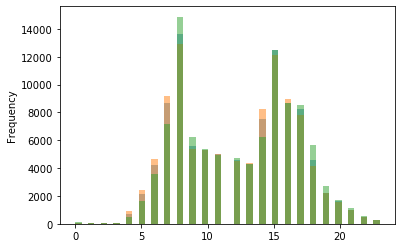

In [78]:
%%time
"""Time Period Adjustment."""
time_filt = trip.copy()

time_filt['MidTime'] = (((time_filt['STARTIME'] + (time_filt['TRAVTIME']/2)).round(1) + 4*60)/60) %24
time_filt['MidTimeHr'] = time_filt['MidTime'].apply(np.floor)
time_filt['StartHr'] = (((time_filt['STARTIME'] + 4*60)/60) %24).apply(np.floor)
time_filt['EndHr'] = (((time_filt['STARTIME'] + time_filt['TRAVTIME'] + 4*60)/60) %24).apply(np.floor)

time_filt['MidTimeHr'].plot.hist(bins=48,alpha =0.5)
time_filt['StartHr'].plot.hist(bins=48,alpha =0.5)
time_filt['EndHr'].plot.hist(bins=48,alpha =0.5)
trip = time_filt
del time_filt


## Mode Adjustments
In this section, we assing MODELMODE and PT_access for each trip. To reach this goal, we follow the following steps successively:

1. Consider left modes as right modes (MAINMODE, MODE1, MODE2, ..., MODE8):
    Truck driver, Motorcycle driver, Other method -----> Car driver
    Truck passenger, Motorcycle passenger, Taxi, Taxi or Uber, Taxi or ride share e.g. Uber, Uber / Other Ride Share -----> Car passenger ( TODO: we use a look up table to aggregate modes. e.g. above examples)  
    Mobility scooter -----> Bicycle
    
2. Define MODELMODE according to the modified MAINMODE (in step 1) as Car driver, Car passenger, Bicycle and Walking. MODELNAME for other MAINMODEs will be defined in the next steps. Thus, if MAINMODE of a trip is within the above group of modes, its MODELNAME is defined, otherwise its MODELNAME is not defined yet. (TODO: efine MODELMODE according to the look up table)

3. Consider left modes as right modes (MAINMODE, MODE1, MODE2, ..., MODE8):
    Public Bus, Charter/Courtesy/Other bus -----> Public bus
    School bus (private/chartered), School bus (with route number) -----> School bus
    
4. Based on the number of stops in a trip and its MODE1, MODE2, ..., MODE8, we define MODELNAME. Some general points about this allocation is as stated below:
    * Trips with 0 stop (only having MODE1) and without MODELNAME get this property equal to their MAINMODE. In additon, their PT_access is Walk2PT.

    * Trips with n>=1 stop (only having MODE1, MODE2, ... MODE_n+1) and without MODELNAME get this property equal to their MAINMODE. In additon, their PT_access is:
     - if their MODE1 is within walking, car driver or car passenger and their last MODE (MODE_n+1) is not within this group : PT_access is defined based on the MODE1.
 
     - if their MODE1 is within walking, car driver or car passenger and their last MODE (MODE_n+1) is within this group too: PT_access is defined based on the last MODE (MODE_n+1).
 
     - if their MODE1 is not within walking, car driver or car passenger and their last MODE (MODE_n+1) is within this group: PT_access is defined based on the last MODE (MODE_n+1).
 
     - if their MODE1 is not within walking, car driver or car passenger and their last MODE (MODE_n+1) is not within this group too: PT_access is defined as Walk2PT.
 
**IMPORTANT NOTE**: For trips with number of stops equal or greater than 2 stops (having at least MODE1, MODE2, MODE3), the trip direction as P2A, A2P and OD is considered too to define PT_access. For example, for a trips with two stops, if MODE1 = car driver and MODE3 (last MODE) != (Car driver | car passenger | walking), we cannot say this trip PT_access is not defined based on its MODE1 as "PnR" since its direction is A2P (not P2A or OD) and it will be defined as Walk2PT at the end. 

**Question 1: Is is correct to consider direction? If so, why shouldn't we consider it for trips with one stop too (having MODE1 and MODE2)?**

**Question 2: Why do we consider only first mode and last mode for defining PT_access?**

**Question 3: PT_access is not defined for trips with MAINMODE (not MODE1, MODE2, ...) of Car driver, Car passenger, Bicycle and Walking. What PT_access should we assign to them?**
    

In [79]:
%%time
"""Mode Adjustments."""
mode_filt = trip.copy()
mode_filt['MODELMODE'] = 0

#Mode Flags

#TODO: create look up table containing predefined matches as below.
mode_filt.replace({'Truck driver': 'Car driver','Truck passenger': 'Car passenger', 'Motorcycle driver': 'Car driver', 'Motorcycle passenger': 'Car passenger','Mobility scooter': 'Bicycle', 'Taxi': 'Car passenger', 'Taxi or Uber': 'Car passenger','Taxi or ride share e.g. Uber' : 'Car passenger', 'Uber / Other Ride Share' : 'Car passenger', 'Other method': 'Car driver'}, inplace = True)

car_driver = mode_filt.MAINMODE == 'Car driver'
car_pass = mode_filt.MAINMODE == 'Car passenger'
single_mode = mode_filt.MODE2 == 0

walk = mode_filt.MAINMODE == 'Walking'
bicycle = mode_filt.MAINMODE == 'Bicycle'
# motorcycle_driver = mode_filt.MAINMODE == 'Motorcycle driver'
# motorcycle_pass = mode_filt.MAINMODE == 'Motorcycle passenger'
# truck_driver = mode_filt.MAINMODE == 'Truck driver'
# truck_pass = mode_filt.MAINMODE == 'Truck passenger'
# mob_scoot = mode_filt.MAINMODE == 'Mobility scooter'
# taxi = mode_filt.MAINMODE == 'Taxi'
# uber = mode_filt.MAINMODE == 'Taxi or Uber'
# ride_share = mode_filt.MAINMODE == 'Taxi or ride share e.g. Uber'

#single modes
mode_filt.loc[car_driver, 'MODELMODE'] = 'Car driver'
mode_filt.loc[car_pass, 'MODELMODE'] = 'Car passenger'
mode_filt.loc[walk, 'MODELMODE'] = 'Walking'
mode_filt.loc[bicycle, 'MODELMODE'] = 'Bicycle'
# mode_filt.loc[motorcycle_driver, 'MODELMODE'] = 'Car driver'
# mode_filt.loc[motorcycle_pass, 'MODELMODE'] = 'Car passenger'
# mode_filt.loc[truck_driver, 'MODELMODE'] = 'Car driver'
# mode_filt.loc[truck_pass, 'MODELMODE'] = 'Car passenger'
# mode_filt.loc[mob_scoot, 'MODELMODE'] = 'Bicycle'
# mode_filt.loc[taxi | uber | ride_share, 'MODELMODE'] = 'Car passenger'

# Atousa: Why in the next two lines, we should consider the single mode condition to reassign the MODELMODE
# mode_filt.loc[truck_driver & single_mode, 'MODELMODE'] = 'Car driver'
# mode_filt.loc[truck_pass & single_mode, 'MODELMODE'] = 'Car passenger'

# mode_filt.replace({'Truck driver': 'Car driver','Truck passenger': 'Car passenger', 'Motorcycle driver': 'Car driver', 'Motorcycle passenger': 'Car passenger','Mobility scooter': 'Bicycle', 'Taxi': 'Car passenger', 'Taxi or Uber': 'Car passenger','Taxi or ride share e.g. Uber' : 'Car passenger', 'Uber / Other Ride Share' : 'Car passenger', 'Other method': 'Car driver'}, inplace = True)

############
# PT MODES #
############
mode_filt.replace({'Public Bus': 'Public bus','Charter/Courtesy/Other bus': 'Public bus', 'School bus (private/chartered)': 'School bus', 'School bus (with route number)': 'School bus'}, inplace = True)

#Num Stops in trip
mode_one = mode_filt.trip_stops == 0
mode_two = mode_filt.trip_stops == 1
mode_three = mode_filt.trip_stops == 2
mode_four = mode_filt.trip_stops == 3
mode_five = mode_filt.trip_stops == 4
mode_six = mode_filt.trip_stops == 5
mode_seven = mode_filt.trip_stops == 6
mode_eight = mode_filt.trip_stops == 7

#direction flag 
a_to_p = mode_filt.Direction == 'A2P'
p_to_a = mode_filt.Direction == 'P2A'
O_to_D = mode_filt.Direction == 'OD'

#PT
# mode_filt.replace({'Public Bus': 'Public bus','Charter/Courtesy/Other bus': 'Public bus', 'School bus (private/chartered)': 'School bus', 'School bus (with route number)': 'School bus'}, inplace = True)
# bus_public = mode_filt.MAINMODE == 'Public bus'
# bus_school = mode_filt.MAINMODE == 'School bus'
# train = mode_filt.MAINMODE == 'Train' 
# light_rail = mode_filt.MAINMODE == 'Light rail' 
# ferry = mode_filt.MAINMODE == 'Ferry' 
mode_filt['PT_access'] = 'None'
not_car = mode_filt.MAINMODE != 'Car driver'
not_car_p = mode_filt.MAINMODE != 'Car passenger'
##PNR KNR W2PT one 
empty = mode_filt.MODELMODE == 0
mode_filt.loc[mode_one & empty & not_car & not_car_p, 'MODELMODE'] = mode_filt.loc[mode_one & empty, 'MAINMODE']

# Atousa: Next three conditions (walk1, drive1 and dropped1) are added, since these MODE1 are not considered to define PT_access
# for mode_one trips

empty_pt_ac = mode_filt.PT_access == 'None'

mode_filt.loc[mode_one & empty & empty_pt_ac & not_car & not_car_p, 'PT_access'] = 'Walk2PT'

##PNR KNR W2PT two 
empty = mode_filt.MODELMODE == 0
mode_filt.loc[mode_two & empty & not_car & not_car_p, 'MODELMODE'] = mode_filt.loc[mode_two & empty, 'MAINMODE']

walk2 = mode_filt.MODE1 == 'Walking'
drive2 = mode_filt.MODE1 == 'Car driver'
dropped2 = mode_filt.MODE1 == 'Car passenger'
mode_filt.loc[mode_two & empty & walk2 & not_car & not_car_p, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_two & empty & drive2 & not_car & not_car_p, 'PT_access'] = 'PnR'
mode_filt.loc[mode_two & empty & dropped2 & not_car & not_car_p, 'PT_access'] = 'KnR'

walk3 = mode_filt.MODE2 == 'Walking'
drive3 = mode_filt.MODE2 == 'Car driver'
dropped3 = mode_filt.MODE2 == 'Car passenger'
mode_filt.loc[mode_two & empty & walk3 & not_car & not_car_p, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_two & empty & drive3 & not_car & not_car_p, 'PT_access'] = 'PnR'
mode_filt.loc[mode_two & empty & dropped3 & not_car & not_car_p, 'PT_access'] = 'KnR'
empty_pt_ac = mode_filt.PT_access == 'None'
mode_filt.loc[mode_two & empty & empty_pt_ac & not_car & not_car_p, 'PT_access'] = 'Walk2PT'

Wall time: 7.3 s


In [80]:
##PNR KNR W2PT three 
empty = mode_filt.MODELMODE == 0
mode_filt.loc[mode_three & empty, 'MODELMODE'] = mode_filt.loc[mode_three & empty, 'MAINMODE']

walk2 = mode_filt.MODE1 == 'Walking'
drive2 = mode_filt.MODE1 == 'Car driver'
dropped2 = mode_filt.MODE1 == 'Car passenger'
mode_filt.loc[mode_three & empty & p_to_a & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_three & empty & p_to_a & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_three & empty & p_to_a & dropped2, 'PT_access'] = 'KnR'
mode_filt.loc[mode_three & empty & O_to_D & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_three & empty & O_to_D & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_three & empty & O_to_D & dropped2, 'PT_access'] = 'KnR'
walk3 = mode_filt.MODE3 == 'Walking'
drive3 = mode_filt.MODE3 == 'Car driver'
dropped3 = mode_filt.MODE3 == 'Car passenger'
mode_filt.loc[mode_three & empty & a_to_p & walk3, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_three & empty & a_to_p & drive3, 'PT_access'] = 'PnR'
mode_filt.loc[mode_three & empty & a_to_p & dropped3, 'PT_access'] = 'KnR'

empty_pt_ac = mode_filt.PT_access == 'None'
mode_filt.loc[mode_three & empty & empty_pt_ac, 'PT_access'] = 'Walk2PT'

In [81]:
##PNR KNR W2PT four
empty = mode_filt.MODELMODE == 0
mode_filt.loc[mode_four & empty, 'MODELMODE'] = mode_filt.loc[mode_four & empty, 'MAINMODE']

walk2 = mode_filt.MODE1 == 'Walking'
drive2 = mode_filt.MODE1 == 'Car driver'
dropped2 = mode_filt.MODE1 == 'Car passenger'
mode_filt.loc[mode_four & empty & p_to_a & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_four & empty & p_to_a & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_four & empty & p_to_a & dropped2, 'PT_access'] = 'KnR'
mode_filt.loc[mode_four & empty & O_to_D & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_four & empty & O_to_D & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_four & empty & O_to_D & dropped2, 'PT_access'] = 'KnR'
walk3 = mode_filt.MODE4 == 'Walking'
drive3 = mode_filt.MODE4 == 'Car driver'
dropped3 = mode_filt.MODE4 == 'Car passenger'
mode_filt.loc[mode_four & empty & a_to_p & walk3, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_four & empty & a_to_p & drive3, 'PT_access'] = 'PnR'
mode_filt.loc[mode_four & empty & a_to_p & dropped3, 'PT_access'] = 'KnR'

empty_pt_ac = mode_filt.PT_access == 'None'
mode_filt.loc[mode_four & empty & empty_pt_ac, 'PT_access'] = 'Walk2PT'

##PNR KNR W2PT five
empty = mode_filt.MODELMODE == 0
mode_filt.loc[mode_five & empty, 'MODELMODE'] = mode_filt.loc[mode_five & empty, 'MAINMODE']

walk2 = mode_filt.MODE1 == 'Walking'
drive2 = mode_filt.MODE1 == 'Car driver'
dropped2 = mode_filt.MODE1 == 'Car passenger'
mode_filt.loc[mode_five & empty & p_to_a & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_five & empty & p_to_a & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_five & empty & p_to_a & dropped2, 'PT_access'] = 'KnR'
mode_filt.loc[mode_five & empty & O_to_D & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_five & empty & O_to_D & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_five & empty & O_to_D & dropped2, 'PT_access'] = 'KnR'
walk3 = mode_filt.MODE5 == 'Walking'
drive3 = mode_filt.MODE5 == 'Car driver'
dropped3 = mode_filt.MODE5 == 'Car passenger'
mode_filt.loc[mode_five & empty & a_to_p & walk3, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_five & empty & a_to_p & drive3, 'PT_access'] = 'PnR'
mode_filt.loc[mode_five & empty & a_to_p & dropped3, 'PT_access'] = 'KnR'

empty_pt_ac = mode_filt.PT_access == 'None'
mode_filt.loc[mode_five & empty & empty_pt_ac, 'PT_access'] = 'Walk2PT'

In [82]:
##PNR KNR W2PT six
empty = mode_filt.MODELMODE == 0
mode_filt.loc[mode_six & empty, 'MODELMODE'] = mode_filt.loc[mode_six & empty, 'MAINMODE']

walk2 = mode_filt.MODE1 == 'Walking'
drive2 = mode_filt.MODE1 == 'Car driver'
dropped2 = mode_filt.MODE1 == 'Car passenger'
mode_filt.loc[mode_six & empty & p_to_a & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_six & empty & p_to_a & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_six & empty & p_to_a & dropped2, 'PT_access'] = 'KnR'
mode_filt.loc[mode_six & empty & O_to_D & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_six & empty & O_to_D & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_six & empty & O_to_D & dropped2, 'PT_access'] = 'KnR'
walk3 = mode_filt.MODE6 == 'Walking'
drive3 = mode_filt.MODE6 == 'Car driver'
dropped3 = mode_filt.MODE6 == 'Car passenger'
mode_filt.loc[mode_six & empty & a_to_p & walk3, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_six & empty & a_to_p & drive3, 'PT_access'] = 'PnR'
mode_filt.loc[mode_six & empty & a_to_p & dropped3, 'PT_access'] = 'KnR'

empty_pt_ac = mode_filt.PT_access == 'None'
mode_filt.loc[mode_six & empty & empty_pt_ac, 'PT_access'] = 'Walk2PT'

In [83]:
##PNR KNR W2PT seven
empty = mode_filt.MODELMODE == 0
mode_filt.loc[mode_seven & empty, 'MODELMODE'] = mode_filt.loc[mode_seven & empty, 'MAINMODE']

walk2 = mode_filt.MODE1 == 'Walking'
drive2 = mode_filt.MODE1 == 'Car driver'
dropped2 = mode_filt.MODE1 == 'Car passenger'
mode_filt.loc[mode_seven & empty & p_to_a & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_seven & empty & p_to_a & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_seven & empty & p_to_a & dropped2, 'PT_access'] = 'KnR'
mode_filt.loc[mode_seven & empty & O_to_D & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_seven & empty & O_to_D & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_seven & empty & O_to_D & dropped2, 'PT_access'] = 'KnR'
walk3 = mode_filt.MODE7 == 'Walking'
drive3 = mode_filt.MODE7 == 'Car driver'
dropped3 = mode_filt.MODE7 == 'Car passenger'
mode_filt.loc[mode_seven & empty & a_to_p & walk3, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_seven & empty & a_to_p & drive3, 'PT_access'] = 'PnR'
mode_filt.loc[mode_seven & empty & a_to_p & dropped3, 'PT_access'] = 'KnR'

empty_pt_ac = mode_filt.PT_access == 'None'
mode_filt.loc[mode_seven & empty & empty_pt_ac, 'PT_access'] = 'Walk2PT'

In [84]:
##PNR KNR W2PT eight
empty = mode_filt.MODELMODE == 0
mode_filt.loc[mode_eight & empty, 'MODELMODE'] = mode_filt.loc[mode_eight & empty, 'MAINMODE']

walk2 = mode_filt.MODE1 == 'Walking'
drive2 = mode_filt.MODE1 == 'Car driver'
dropped2 = mode_filt.MODE1 == 'Car passenger'
mode_filt.loc[mode_eight & empty & p_to_a & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_eight & empty & p_to_a & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_eight & empty & p_to_a & dropped2, 'PT_access'] = 'KnR'
mode_filt.loc[mode_eight & empty & O_to_D & walk2, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_eight & empty & O_to_D & drive2, 'PT_access'] = 'PnR'
mode_filt.loc[mode_eight & empty & O_to_D & dropped2, 'PT_access'] = 'KnR'
walk3 = mode_filt.MODE8 == 'Walking'
drive3 = mode_filt.MODE8 == 'Car driver'
dropped3 = mode_filt.MODE8 == 'Car passenger'
mode_filt.loc[mode_eight & empty & a_to_p & walk3, 'PT_access'] = 'Walk2PT'
mode_filt.loc[mode_eight & empty & a_to_p & drive3, 'PT_access'] = 'PnR'
mode_filt.loc[mode_eight & empty & a_to_p & dropped3, 'PT_access'] = 'KnR'

empty_pt_ac = mode_filt.PT_access == 'None'
mode_filt.loc[mode_eight & empty & empty_pt_ac, 'PT_access'] = 'Walk2PT'

# del empty_pt_ac, walk2, walk3, drive2, drive3, dropped2, dropped3, empty
# del a_to_p, p_to_a, O_to_D, mode_one, mode_two, mode_three, mode_four
# del mode_five, mode_six, mode_seven, mode_eight
# del car_driver, car_pass, motorcycle_driver, motorcycle_pass
# del bicycle
# del not_car, not_car_p, ride_share, single_mode, taxi
# del train, truck_driver, truck_pass, uber, walk

print('Number of Trip Records in Original: {}'.format(len(TRIPS.axes[0])))
print('Number of Trip Records: {}'.format(len(mode_filt.axes[0])))
trip = mode_filt
del mode_filt

Number of Trip Records in Original: 101642
Number of Trip Records: 101642


In [85]:
%%time
"""GIS tagging."""
trip_prod = gpd.GeoDataFrame(trip, geometry = gpd.points_from_xy(trip['PROD_LONG'], trip['PROD_LAT']))
# trip_prod = trip_prod.set_crs(zones.crs)
trip_prod.crs=zones.crs
# Atousa Modification
trip_prod = gpd.sjoin(trip_prod, zones[['geometry','LvL4_ID', 'LvL3_ID', 'LvL2_ID', 'LvL1_ID', 'Dist_ID', 'BSTM']], how = 'left', op = 'within').drop(columns ='index_right').rename(columns = {'LvL4_ID': 'PROD_LvL4', 'LvL3_ID': 'PROD_LvL3', 'LvL2_ID': 'PROD_LvL2','LvL1_ID': 'PROD_LvL1', 'Dist_ID': 'PROD_Dist', 'BSTM': 'PROD_BSTM'})
# trip_prod = gpd.sjoin(trip_prod, zones[['geometry','LvL4_ID', 'LvL3_ID', 'LvL2_ID', 'LvL1_ID', 'Dist_ID']], how = 'left', op = 'within').drop(columns ='index_right').rename(columns = {'LvL4_ID': 'PROD_LvL4', 'LvL3_ID': 'PROD_LvL3', 'LvL2_ID': 'PROD_LvL2','LvL1_ID': 'PROD_LvL1', 'Dist_ID': 'PROD_Dist'})

##trip_prod.to_file('tripprod.shp', driver='ESRI Shapefile')

trip_attr = gpd.GeoDataFrame(trip_prod.drop(columns = ['geometry']), geometry = gpd.points_from_xy(trip['ATTR_LONG'], trip['ATTR_LAT']))
# trip_attr = trip_attr.set_crs(zones.crs)
trip_attr.crs=zones.crs
#Atousa Modification:
trip_attr = gpd.sjoin(trip_attr, zones[['geometry','LvL4_ID', 'LvL3_ID', 'LvL2_ID', 'LvL1_ID', 'Dist_ID','BSTM']], how = 'left', op = 'within').drop(columns ='index_right').rename(columns = {'LvL4_ID': 'ATTR_LvL4', 'LvL3_ID': 'ATTR_LvL3', 'LvL2_ID': 'ATTR_LvL2','LvL1_ID': 'ATTR_LvL1', 'Dist_ID': 'ATTR_Dist','BSTM': 'ATTR_BSTM'})
# trip_attr = gpd.sjoin(trip_attr, zones[['geometry','LvL4_ID', 'LvL3_ID', 'LvL2_ID', 'LvL1_ID', 'Dist_ID']], how = 'left', op = 'within').drop(columns ='index_right').rename(columns = {'LvL4_ID': 'ATTR_LvL4', 'LvL3_ID': 'ATTR_LvL3', 'LvL2_ID': 'ATTR_LvL2','LvL1_ID': 'ATTR_LvL1', 'Dist_ID': 'ATTR_Dist'})

## trip_attr[[ 'PROD_LvL4', 'PROD_LvL3', 'PROD_LvL2', 'PROD_LvL1', 'PROD_Dist', 'ATTR_LvL4', 'ATTR_LvL3', 'ATTR_LvL2', 'ATTR_LvL1', 'ATTR_Dist']]
## trip_attr.to_file('tripattr.shp', driver='ESRI Shapefile')
trip_p = pd.DataFrame(trip_attr.drop(columns = ['geometry']))
trip = trip_p
#Atousa Modification: BSTMs
trip.loc[trip['Direction'] == 'P2A', 'Orig_Dist'] = trip.loc[trip['Direction'] == 'P2A', 'PROD_Dist']
trip.loc[trip['Direction'] == 'P2A', 'Orig_Mod'] = trip.loc[trip['Direction'] == 'P2A', 'PROD_BSTM']
trip.loc[trip['Direction'] == 'P2A', 'Dest_Dist'] = trip.loc[trip['Direction'] == 'P2A', 'ATTR_Dist']
trip.loc[trip['Direction'] == 'P2A', 'Dest_Mod'] = trip.loc[trip['Direction'] == 'P2A', 'ATTR_BSTM']

trip.loc[trip['Direction'] == 'OD', 'Orig_Dist'] = trip.loc[trip['Direction'] == 'OD', 'PROD_Dist']
trip.loc[trip['Direction'] == 'OD', 'Orig_Mod'] = trip.loc[trip['Direction'] == 'OD', 'PROD_BSTM']
trip.loc[trip['Direction'] == 'OD', 'Dest_Dist'] = trip.loc[trip['Direction'] == 'OD', 'ATTR_Dist']
trip.loc[trip['Direction'] == 'OD', 'Dest_Mod'] = trip.loc[trip['Direction'] == 'OD', 'ATTR_BSTM']

trip.loc[trip['Direction'] == 'A2P', 'Orig_Dist'] = trip.loc[trip['Direction'] == 'A2P', 'ATTR_Dist']
trip.loc[trip['Direction'] == 'A2P', 'Orig_Mod'] = trip.loc[trip['Direction'] == 'A2P', 'ATTR_BSTM']
trip.loc[trip['Direction'] == 'A2P', 'Dest_Dist'] = trip.loc[trip['Direction'] == 'A2P', 'PROD_Dist']
trip.loc[trip['Direction'] == 'A2P', 'Dest_Mod'] = trip.loc[trip['Direction'] == 'A2P', 'PROD_BSTM']

# Atousa Modification:
a = trip.Orig_Mod == 'Y'
b = trip.Orig_Mod == 'N'
trip.loc[a | b, 'ORIG_SEQ'] = 'Y'
trip.loc[trip.ORIG_SEQ != 'Y', 'ORIG_SEQ'] = 'N'
c = trip.Dest_Mod == 'Y'
d = trip.Dest_Mod == 'N'
trip.loc[c | d, 'DEST_SEQ'] = 'Y'
trip.loc[trip.DEST_SEQ != 'Y', 'DEST_SEQ'] = 'N'




trip['AGE5'] = (trip['AGE'] // 5 ) *5
trip['AGE10'] = (trip['AGE'] // 10 ) *10


del trip_attr, trip_prod, trip_p

Wall time: 29.7 s


In [86]:
%%time
"""Clean Tables of non SEQ Based Households"""
Household = Household[Household.Home_Dist.notnull()]
Person = Person[Person.Home_Dist.notnull()]
trip = trip[trip.Home_Dist.notnull()]
Household = Household[Household.Home_Dist > 0]
Person = Person[Person.Home_Dist > 0]
trip = trip[trip.Home_Dist > 0]

print('Number of Household Records in Original: {}'.format(len(HOUSEHOLDS.axes[0])))
print('Number of Household Records: {}'.format(len(Household.axes[0])))
print('Number of Trip Records in Original: {}'.format(len(TRIPS.axes[0])))
print('Number of Trip Records: {}'.format(len(trip.axes[0])))
print('Number of Person Records in Original: {}'.format(len(PERSONS.axes[0])))
print('Number of Person Records: {}'.format(len(Person.axes[0])))


trip.drop(columns = ['STARTSTOP', 'STARTSTOP', 'ENDSTOP', 'MAINMODE', 'MODE1','MODE2','MODE3','MODE4', 'MODE5','MODE6', 'MODE7', 'MODE8', 'MidTime', 'ARRTIME','OVERALL_PURPOSE'], inplace = True)

#Atousa: 
a = trip.ORIG_SEQ == 'Y'
b = trip.DEST_SEQ == 'Y'
na = trip.ORIG_SEQ != 'Y'
nb = trip.DEST_SEQ != 'Y'
# Atousa end

#int_trips = trip.loc[a & b]
#i2e_trips = trip.loc[a & nb]
#e2i_trips = trip.loc[na & b]
#e2e_trips = trip.loc[na & nb]
#Atousa:
internal_trips = trip.loc[a | b]


# del a,b,na,nb

Number of Household Records in Original: 14715
Number of Household Records: 14715
Number of Trip Records in Original: 101642
Number of Trip Records: 101642
Number of Person Records in Original: 36264
Number of Person Records: 36264
Wall time: 476 ms


In [87]:
sect = wgt_sect[['Dist_ID', 'WeightingSector']]
trip = pd.merge(trip, sect, left_on = 'Home_Dist', right_on='Dist_ID', how='left').rename(columns={'WeightingSector': "Home_Sect"}).drop(columns='Dist_ID')
trip = pd.merge(trip, sect, left_on = 'PROD_Dist', right_on='Dist_ID', how='left').rename(columns={'WeightingSector': "PROD_Sect"}).drop(columns='Dist_ID')
trip = pd.merge(trip, sect, left_on = 'ATTR_Dist', right_on='Dist_ID', how='left').rename(columns={'WeightingSector': "ATTR_Sect"}).drop(columns='Dist_ID')
Person = pd.merge(Person, sect, left_on = 'Home_Dist', right_on='Dist_ID', how='left').rename(columns={'WeightingSector': "Home_Sect"}).drop(columns='Dist_ID')


In [ ]:
Person_I2I = pd.merge(Person,pd.pivot_table(internal_trips, values = ['TRIPID','TRIPWGT19'], index = ['PERSID'], columns = ['Trip_Purpose'], aggfunc={'TRIPID': 'count','TRIPWGT19':'sum'}), on ='PERSID', how = 'left' )#.fillna(0)

Person_I2I = pd.merge(Person_I2I, internal_trips.groupby(by=['PERSID']).agg({'TRIPID':'count','TRIPWGT19':'sum'}), on='PERSID', how='left')
Person_I2I.to_csv('..\Data\output\Person_regression.csv', index=False)
Person_I2I = pd.read_csv('..\Data\output\Person_regression.csv')

Person_I2I.fillna(0, inplace = True)
Person_I2I.columns = Person_I2I.columns.str.replace("'",'')
Person_I2I.columns = Person_I2I.columns.str.replace(",",'')
Person_I2I.columns = Person_I2I.columns.str.replace("(",'')
Person_I2I.columns = Person_I2I.columns.str.replace(")",'')
Person_I2I.columns = Person_I2I.columns.str.replace("TRIPID",'UW_')
Person_I2I.columns = Person_I2I.columns.str.replace("TRIPWGT19",'W_')
Person_I2I.columns = Person_I2I.columns.str.replace(" ",'')
Person_I2I.rename(columns={'W_':'Weighted','UW_':'Un-weighted'}, inplace= True)

"""Retroactive Person-Type Change"""
"""Taken care of by prior steps"""

In [ ]:
##Demographic Variables
non_work_flag = Person_I2I['Dependent'] == 1
worker_flag = Person_I2I['Worker'] == 1
student_flag = Person_I2I['Student'] == 1
non_student_flag = Person_I2I['Student'] != 1
worker_b_flag = Person_I2I['Worker_Blue'] == 1
worker_w_flag = Person_I2I['Worker_White'] == 1
student_t_flag = Person_I2I['Student_Tert'] == 1
student_s_flag = Person_I2I['Student_Sec'] == 1
student_p_flag = Person_I2I['Student_Prim'] == 1


Person_I2I.loc[non_work_flag & non_student_flag, 'Non-work, non-study'] = 1
Person_I2I.loc[non_work_flag & non_student_flag, 'Demog Classification' ] = 'Non-work, non-study'
Person_I2I.loc[non_work_flag & non_student_flag, 'Demog Classification2' ] = 'Non-work, non-study'

Person_I2I.loc[worker_flag & non_student_flag, 'Work, non-study'] = 1
Person_I2I.loc[worker_flag & non_student_flag, 'Demog Classification' ] = 'Work, non-study'
Person_I2I.loc[worker_flag & worker_w_flag & non_student_flag, 'Work_white, non-study'] = 1
Person_I2I.loc[worker_flag & worker_w_flag & non_student_flag, 'Demog Classification2' ] = 'Work_white, non-study'
Person_I2I.loc[worker_flag & worker_w_flag & non_student_flag, 'Work_blue, non-study'] = 1
Person_I2I.loc[worker_flag & worker_b_flag & non_student_flag, 'Demog Classification2' ] = 'Work_blue, non-study'


Person_I2I.loc[worker_flag & student_flag, 'Work, study'] = 1
Person_I2I.loc[worker_flag & student_flag, 'Demog Classification' ] = 'Work, study'
Person_I2I.loc[worker_flag & worker_w_flag & student_flag & student_t_flag, 'Work_White, study_tert'] = 1
Person_I2I.loc[worker_flag & worker_w_flag & student_flag & student_t_flag, 'Demog Classification2' ] = 'Work_white, study_tert'
Person_I2I.loc[worker_flag & worker_w_flag & student_flag & student_t_flag, 'Work_Blue, study_tert'] = 1
Person_I2I.loc[worker_flag & worker_b_flag & student_flag & student_t_flag, 'Demog Classification2' ] = 'Work_Blue, study_tert'
Person_I2I.loc[worker_flag & worker_w_flag & student_flag & student_s_flag, 'Work_White, study_sec'] = 1
Person_I2I.loc[worker_flag & worker_w_flag & student_flag & student_s_flag, 'Demog Classification2' ] = 'Work_white, study_sec'
Person_I2I.loc[worker_flag & worker_w_flag & student_flag & student_s_flag, 'Work_Blue, study_sec'] = 1
Person_I2I.loc[worker_flag & worker_b_flag & student_flag & student_s_flag, 'Demog Classification2' ] = 'Work_Blue, study_sec'

Person_I2I.loc[non_work_flag & student_flag, 'Non-work, study'] = 1
Person_I2I.loc[non_work_flag & student_flag, 'Demog Classification' ] = 'Non-work, study'
Person_I2I.loc[non_work_flag & student_flag & student_p_flag, 'Non-work, study_prim'] = 1
Person_I2I.loc[non_work_flag & student_flag & student_p_flag, 'Demog Classification2' ] = 'Non-work, study_prim'
Person_I2I.loc[non_work_flag & student_flag & student_s_flag, 'Non-work, study_sec'] = 1
Person_I2I.loc[non_work_flag & student_flag & student_s_flag, 'Demog Classification2' ] = 'Non-work, study_sec'
Person_I2I.loc[non_work_flag & student_flag & student_t_flag, 'Non-work, study_tert'] = 1
Person_I2I.loc[non_work_flag & student_flag & student_t_flag, 'Demog Classification2' ] = 'Non-work, study_tert'

trip_non_work_flag = trip['Dependent'] == 1
trip_worker_flag = trip['Worker'] == 1
trip_student_flag = trip['Student'] == 1
trip_non_student_flag = trip['Student'] != 1
trip_worker_b_flag = trip['Worker_Blue'] == 1
trip_worker_w_flag = trip['Worker_White'] == 1
trip_student_t_flag = trip['Student_Tert'] == 1
trip_student_s_flag = trip['Student_Sec'] == 1
trip_student_p_flag = trip['Student_Prim'] == 1

In [366]:
#trip_retired_flag = trip['WORKSTATUS'] == 'retired'

trip.loc[trip_non_work_flag & trip_non_student_flag, 'Non-work, non-study'] = 1
trip.loc[trip_non_work_flag & trip_non_student_flag, 'Demog Classification' ] = 'Non-work, non-study'
trip.loc[trip_non_work_flag & trip_non_student_flag, 'Demog Classification2' ] = 'Non-work, non-study'

trip.loc[trip_worker_flag & trip_non_student_flag, 'Work, non-study'] = 1
trip.loc[trip_worker_flag & trip_non_student_flag, 'Demog Classification' ] = 'Work, non-study'
trip.loc[trip_worker_flag & trip_worker_w_flag & trip_non_student_flag, 'Work_white, non-study'] = 1
trip.loc[trip_worker_flag & trip_worker_w_flag & trip_non_student_flag, 'Demog Classification2' ] = 'Work_white, non-study'
trip.loc[trip_worker_flag & trip_worker_w_flag & trip_non_student_flag, 'Work_blue, non-study'] = 1
trip.loc[trip_worker_flag & trip_worker_b_flag & trip_non_student_flag, 'Demog Classification2' ] = 'Work_blue, non-study'

trip.loc[trip_worker_flag & trip_student_flag, 'Work, study'] = 1
trip.loc[trip_worker_flag & trip_student_flag, 'Demog Classification' ] = 'Work, study'
trip.loc[trip_worker_flag & trip_worker_w_flag & trip_student_flag & trip_student_t_flag, 'Work_White, study_tert'] = 1
trip.loc[trip_worker_flag & trip_worker_w_flag & trip_student_flag & trip_student_t_flag, 'Demog Classification2' ] = 'Work_white, study_tert'
trip.loc[trip_worker_flag & trip_worker_w_flag & trip_student_flag & trip_student_t_flag, 'Work_Blue, study_tert'] = 1
trip.loc[trip_worker_flag & trip_worker_b_flag & trip_student_flag & trip_student_t_flag, 'Demog Classification2' ] = 'Work_Blue, study_tert'
trip.loc[trip_worker_flag & trip_worker_w_flag & trip_student_flag & trip_student_s_flag, 'Work_White, study_sec'] = 1
trip.loc[trip_worker_flag & trip_worker_w_flag & trip_student_flag & trip_student_s_flag, 'Demog Classification2' ] = 'Work_white, study_sec'
trip.loc[trip_worker_flag & trip_worker_w_flag & trip_student_flag & trip_student_s_flag, 'Work_Blue, study_sec'] = 1
trip.loc[trip_worker_flag & trip_worker_b_flag & trip_student_flag & trip_student_s_flag, 'Demog Classification2' ] = 'Work_Blue, study_sec'

trip.loc[trip_non_work_flag & trip_student_flag, 'Non-work, study'] = 1
trip.loc[trip_non_work_flag & trip_student_flag, 'Demog Classification' ] = 'Non-work, study'
trip.loc[trip_non_work_flag & trip_student_flag & trip_student_p_flag, 'Non-work, study_prim'] = 1
trip.loc[trip_non_work_flag & trip_student_flag & trip_student_p_flag, 'Demog Classification2' ] = 'Non-work, study_prim'
trip.loc[trip_non_work_flag & trip_student_flag & trip_student_p_flag, 'Non-work, study_sec'] = 1
trip.loc[trip_non_work_flag & trip_student_flag & trip_student_p_flag, 'Demog Classification2' ] = 'Non-work, study_sec'
trip.loc[trip_non_work_flag & trip_student_flag & trip_student_p_flag, 'Non-work, study_tert'] = 1
trip.loc[trip_non_work_flag & trip_student_flag & trip_student_p_flag, 'Demog Classification2' ] = 'Non-work, study_tert'

"""Flexible Workers."""
nonflex = Person_I2I.Collar2 == "White Non-Flexible"
flex = Person_I2I.Collar2 == "White Flexible"
non_rec = Person_I2I.Collar2 == 0
white_worker = Person_I2I.Worker_White == 1

Person_I2I['Worker_White_F'] = 0
Person_I2I['Worker_White_NF'] = 0
Person_I2I.loc[white_worker & flex, 'Worker_White_F'] = 1
Person_I2I.loc[white_worker & nonflex, 'Worker_White_NF'] = 1
Person_I2I.loc[white_worker & non_rec, 'Worker_White_NF'] = 1


Person_I2I['UW_HBWW_NF'] = 0
Person_I2I['UW_HBWW_F'] = 0
Person_I2I['W_HBWW_NF'] = 0
Person_I2I['W_HBWW_F'] = 0

Person_I2I.loc[white_worker & flex,    'UW_HBWW_F'] = Person_I2I.loc[white_worker & flex,    'UW_HBWW']
Person_I2I.loc[white_worker & nonflex, 'UW_HBWW_NF'] = Person_I2I.loc[white_worker & nonflex, 'UW_HBWW']
Person_I2I.loc[white_worker & non_rec, 'UW_HBWW_NF'] = Person_I2I.loc[white_worker & non_rec, 'UW_HBWW']
Person_I2I.loc[white_worker & flex,    'W_HBWW_F'] = Person_I2I.loc[white_worker & flex,    'W_HBWW']
Person_I2I.loc[white_worker & nonflex, 'W_HBWW_NF'] = Person_I2I.loc[white_worker & nonflex, 'W_HBWW']
Person_I2I.loc[white_worker & non_rec, 'W_HBWW_NF'] = Person_I2I.loc[white_worker & non_rec, 'W_HBWW']




Person_I2I['Resident'] = 1
non_study = Person_I2I.Student == 0
Person_I2I.loc[non_study, 'Non-Study'] = 1
Person_I2I.fillna(0, inplace = True)

Person_I2I.to_csv('..\Data\output\Person_regression.csv', index=False)
Person_I2I.to_csv('..\Data\output\Trips_by_Person_pivot (Regression Table).csv', index=False)
Person_I2I.rename(columns ={'HH_SA2': 'SA2','HH_SA3': 'SA3','HH_SA4': 'SA4','HH_LGA': 'LGA', 'Home_Sect':'Sect'}, inplace = True)
Person_I2I.rename(columns ={'Home_LvL4': 'LvL4','Home_LvL3': 'LvL3','Home_LvL2': 'LvL2','Home_LvL1': 'LvL1','Home_Dist': 'Dist'}, inplace = True)
Person_I2I.drop(columns = ['WORKSTATUS','ANZSCO_1-digit', 'ANZSCO_3-digit', 'INDUSTRY', 'STUDYING', 'ED_TYPE', 'MAINACT', 'DEMOGWGT19'], inplace= True)

In [367]:
#Person_I2I = pd.merge(Person_I2I, wgt_sect[['Dist_ID', 'WeightingSector']], left_on='Dist', right_on = 'Dist_ID', how='left').rename(columns={'WeightingSector':'Sect'}).drop(columns=['Dist_ID'])
Person_I2I.to_csv('..\Data\output\Person_regression.csv', index=False)

In [368]:
pivot_ui(Person_I2I, vals=['TRIPID', 'TRIPWGT19'], aggregatorName='Average', rows = ['Dep', 'Workers'], cols=['AGE10'], rendererName ='Table Barchart', outfile_path='..\Data\output\Trips_by_Person_pivot (Regression Table).html')
os.startfile(os.path.join(adjustpath, '..\Data\output\Trips_by_Person_pivot (Regression Table).html'))

In [369]:
%%time
"""Export Tables"""
pivot_ui(trip, vals=['TRIPWGT19'], aggregatorName='Sum', outfile_path='..\Data\output\Trips_pivot.html')
pivot_ui(Household, vals=['PERSWGT19'], aggregatorName='Sum', outfile_path='..\Data\output\Households_pivot.html')
pivot_ui(Person, vals=['PERSWGT19'], aggregatorName='Sum', outfile_path='..\Data\output\Persons_pivot.html')
trip.to_csv('..\Data\output\Trips_table.csv')
Household.to_csv('..\Data\output\Households_table.csv')
Person.to_csv('..\Data\output\Persons_table.csv')


Wall time: 29.5 s


## Appendix
<img src="../Media/appendix.jpg">